# SSL Models Performance Analysis on SurgVU Dataset

This notebook analyzes the performance of Self-Supervised Learning (SSL) models trained on the SurgVU dataset.

## Data Sources:
1. **train_val_results.csv** - validation results during training
2. **test_results.csv** - evaluation results on test set

## Models:
- **ImageNet** - weights pre-trained on ImageNet
- **MoCo** - Momentum Contrast 
- **SimCLR** - Simple Contrastive Learning

## Data Subsets:
- **12.5%** - 1/8 of training data
- **25%** - 1/4 of training data  
- **100%** - full training data

In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configure matplotlib
plt.style.use('default')
# plt.rcParams['figure.figsize'] = (16, 10)
# plt.rcParams['font.size'] = 12

print("📊 SSL Models Performance Analysis on SurgVU Dataset")
print("="*60)

📊 SSL Models Performance Analysis on SurgVU Dataset


## 1. Data Loading and Preparation

In [278]:
# Paths to CSV files in results subdirectory
train_val_file = "../../results/train_val_results.csv"
test_eval_file = "../../results/test_results.csv"

# Check if files exist
print("🔍 Checking files:")
print(f"Train/Val results: {os.path.exists(train_val_file)} - {train_val_file}")
print(f"Test eval results: {os.path.exists(test_eval_file)} - {test_eval_file}")

# Load data
print("\n📁 Loading data...")

# 1. Training/validation data
df_train_val = pd.read_csv(train_val_file)
print(f"✅ Train/Val data: {df_train_val.shape[0]} rows, {df_train_val.shape[1]} columns")

# 2. Test data
df_test = pd.read_csv(test_eval_file)
print(f"✅ Test data: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

print("\n📋 Data preview:")
print("\n--- Train/Val Results ---")
print(df_train_val.head())
print("\n--- Test Evaluation Results ---")
print(df_test.head())

🔍 Checking files:
Train/Val results: True - ../../results/train_val_results.csv
Test eval results: True - ../../results/test_results.csv

📁 Loading data...
✅ Train/Val data: 9 rows, 14 columns
✅ Test data: 9 rows, 10 columns

📋 Data preview:

--- Train/Val Results ---
      model data_subset              job_directory  \
0  ImageNet       12.5%  job_1952602_20251015_1437   
1  ImageNet         25%  job_1952603_20251015_1437   
2  ImageNet        100%  job_1952604_20251015_1437   
3      MoCo       12.5%  job_1953621_20251016_1141   
4      MoCo         25%  job_1953622_20251016_1141   

                                            job_path  \
0  /net/tscratch/people/plgjmachali/surgvu_result...   
1  /net/tscratch/people/plgjmachali/surgvu_result...   
2  /net/tscratch/people/plgjmachali/surgvu_result...   
3  /net/tscratch/people/plgjmachali/surgvu_result...   
4  /net/tscratch/people/plgjmachali/surgvu_result...   

                                     checkpoint_path  checkpoint_exis

In [279]:
# Rename columns for clarity: test_* -> val_* (these are validation results, not test results)
print("🔧 Data preparation...")
print("📝 Renaming columns for clarity: test_* -> val_*")

# Rename validation columns in train_val data
df_train_val = df_train_val.rename(columns={
    'test_f1_macro': 'val_f1_macro',
    'test_f1_weighted': 'val_f1_weighted', 
    'test_accuracy': 'val_accuracy'
})

# Prepare test data - remove unnecessary columns
df_test_clean = df_test[['model', 'data_subset', 'phase', 'test_f1_macro', 'test_f1_weighted', 'test_accuracy']].copy()

model_mapping = {
    'ImageNet': 'ImageNet',
    'MoCo': 'MoCo', 
    'SimCLR': 'SimCLR'
}

model_colors = {'ImageNet': '#1f77b4', 'MoCo': '#ff7f0e', 'SimCLR': '#2ca02c'}

subset_order = ["12.5%", "25%", "100%"]
df_train_val["data_subset"] = pd.Categorical(df_train_val["data_subset"], categories=subset_order, ordered=True)
df_test_clean["data_subset"] = pd.Categorical(df_test_clean["data_subset"], categories=subset_order, ordered=True)

# Check unique values
print(f"\n📊 Models in train/val: {df_train_val['model'].unique()}")
print(f"📊 Models in test: {df_test_clean['model'].unique()}")
print(f"📊 Data subsets: {subset_order}")

🔧 Data preparation...
📝 Renaming columns for clarity: test_* -> val_*

📊 Models in train/val: ['ImageNet' 'MoCo' 'SimCLR']
📊 Models in test: ['ImageNet' 'MoCo' 'SimCLR']
📊 Data subsets: ['12.5%', '25%', '100%']


In [280]:
import pandas as pd

df_train_val_sorted = (
    df_train_val
    .copy()
    .assign(
        data_subset=pd.Categorical(df_train_val["data_subset"], categories=subset_order, ordered=True)
    )
    .sort_values(["data_subset", "model"])
    .round(1)
)

# for LaTeX
df_train_val_sorted["data_subset"] = df_train_val_sorted["data_subset"].astype(str).str.replace("%", r"\%", regex=False)

# (opcjonalnie) pogrub najlepsze Val F1 macro w każdym subsecie
def bold_best_per_subset(df, subset_col, metric_col):
    df = df.copy()
    for subset, g in df.groupby(subset_col):
        if len(g):
            idx = g[metric_col].astype(float).idxmax()
            df.loc[idx, metric_col] = r"\textbf{" + f"{float(df.loc[idx, metric_col]):.1f}" + "}"
    return df

df_out = bold_best_per_subset(df_train_val_sorted, "data_subset", "val_f1_macro")

cols = [
    "data_subset", "model",
    "train_f1_macro", "train_f1_weighted", "train_accuracy",
    "val_f1_macro", "val_f1_weighted", "val_accuracy"
]

headers = [
    "Subset", "Model",
    "Train F1 macro", "Train F1 weighted", "Train Acc.",
    "Val F1 macro", "Val F1 weighted", "Val Acc."
]

latex_table = df_out[cols].to_latex(
    index=False,
    float_format=lambda x: f"{x:.1f}",
    caption="Training and validation performance across labeled regimes for all models. Results are reported as percentages.",
    label="tab:train_val_results",
    column_format="lccccccc",
    header=headers,
    escape=False
)

print(latex_table)

\begin{table}
\caption{Training and validation performance across labeled regimes for all models. Results are reported as percentages.}
\label{tab:train_val_results}
\begin{tabular}{lccccccc}
\toprule
Subset & Model & Train F1 macro & Train F1 weighted & Train Acc. & Val F1 macro & Val F1 weighted & Val Acc. \\
\midrule
12.5\% & ImageNet & 61.1 & 71.3 & 69.5 & 53.7 & 67.5 & 64.5 \\
12.5\% & MoCo & 79.5 & 89.4 & 88.7 & 56.1 & 74.1 & 72.9 \\
12.5\% & SimCLR & 79.9 & 89.3 & 88.6 & \textbf{56.8} & 75.5 & 74.7 \\
25\% & ImageNet & 93.2 & 97.1 & 97.0 & 60.4 & 77.9 & 78.4 \\
25\% & MoCo & 90.2 & 96.1 & 95.9 & 64.7 & 80.8 & 80.6 \\
25\% & SimCLR & 88.2 & 95.3 & 95.0 & \textbf{64.8} & 80.4 & 79.7 \\
100\% & ImageNet & 74.2 & 85.1 & 84.1 & 64.8 & 79.4 & 78.8 \\
100\% & MoCo & 84.7 & 93.1 & 92.7 & \textbf{67.1} & 82.0 & 81.3 \\
100\% & SimCLR & 77.7 & 88.4 & 87.6 & 66.0 & 81.6 & 80.9 \\
\bottomrule
\end{tabular}
\end{table}



## 2. Validation Results Visualization (Train/Val)

In [281]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.size": 11,          # tekst osi, ticki
    "axes.titlesize": 13,     # tytuły pojedynczych subplotów
    "axes.labelsize": 11,     # etykiety osi
    "legend.fontsize": 10,
    "figure.titlesize": 14,   # suptitle
        "figure.dpi": 300,

})

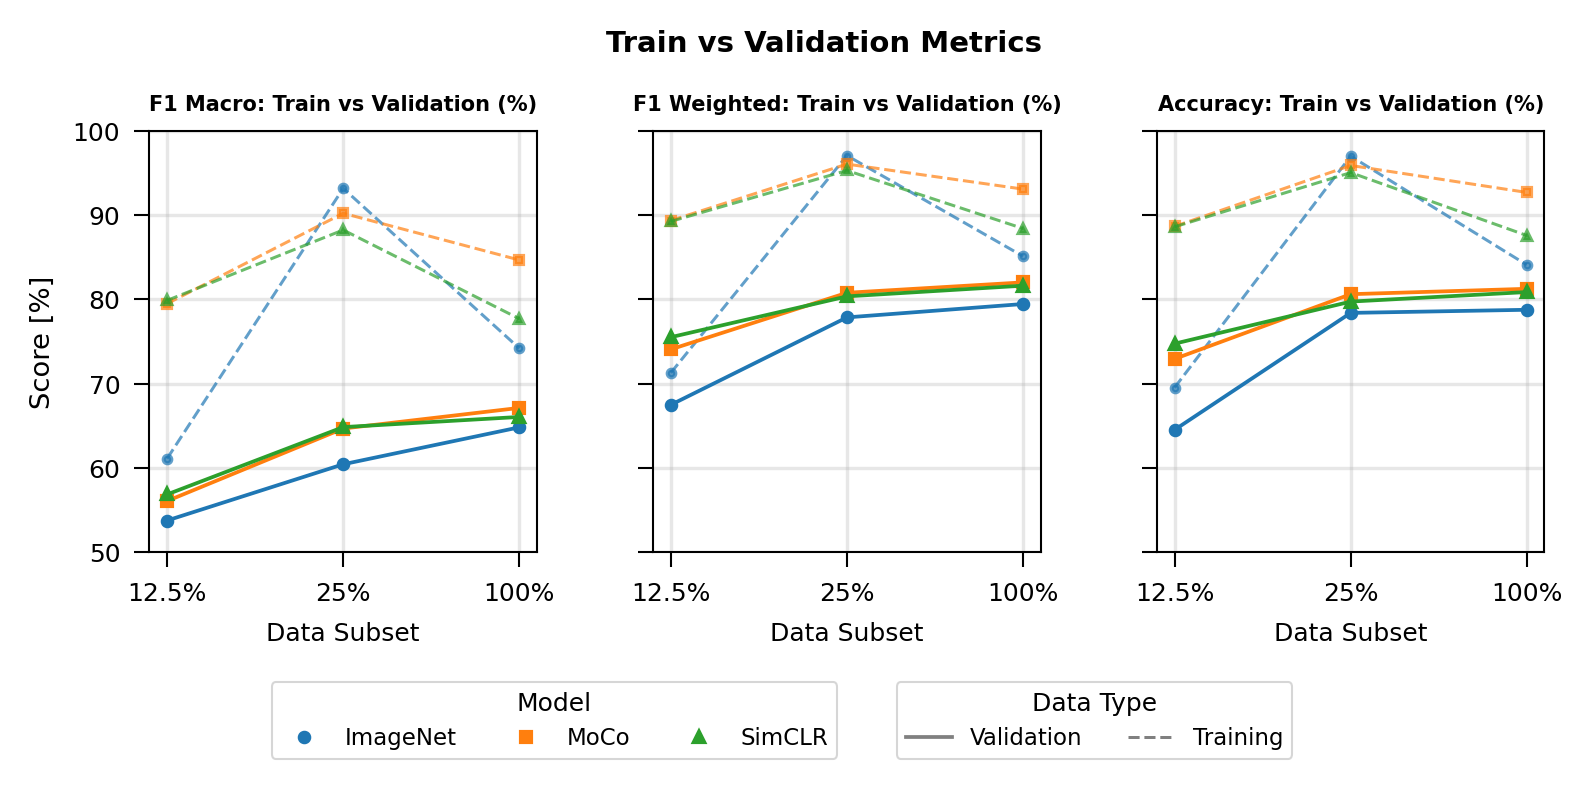

In [282]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


model_colors = {'ImageNet': '#1f77b4', 'MoCo': '#ff7f0e', 'SimCLR': '#2ca02c'}
model_markers = {'ImageNet': 'o', 'MoCo': 's', 'SimCLR': '^'}

SCALE_FACTOR = 0.45  # pod LaTeX 12pt

TITLE_SIZE = int(13 * SCALE_FACTOR)
SUPTITLE_SIZE = int(16 * SCALE_FACTOR)
LABEL_SIZE = int(14 * SCALE_FACTOR)
TICK_SIZE = int(14 * SCALE_FACTOR)
LEGEND_SIZE = int(13 * SCALE_FACTOR)
LABEL_TITLE_FONTSIZE = int(14 * SCALE_FACTOR)

LINE_WIDTH = 2 * SCALE_FACTOR
MARKER_SIZE = 5 * SCALE_FACTOR

FIG_WIDTH, FIG_HEIGHT = 6, 2.6  
# --- Prepare subset ordering ---
def subset_to_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    m = re.search(r"[\d\.]+", str(x))
    return float(m.group()) if m else np.nan

df = df_train_val.copy()
df["subset_num"] = df["data_subset"].apply(subset_to_float)
cat_labels = (
    df.sort_values("subset_num")["data_subset"]
      .dropna().astype(str).drop_duplicates().tolist()
)
df["data_subset"] = pd.Categorical(df["data_subset"], categories=cat_labels, ordered=True)

# --- Helper: plot Train vs Val for a metric ---
def plot_train_vs_val(ax, title, train_col, val_col, ylim=None):
    for model, group in df.groupby("model"):
        g = group.sort_values("data_subset")
        color = model_colors.get(model, None)
        marker = model_markers.get(model, 'o')

        # Val (solid)
        if val_col in g:
            ax.plot(
                g["data_subset"], g[val_col],
                marker=marker, linewidth=LINE_WIDTH, markersize=MARKER_SIZE,
                color=color
            )
        # Train (dashed)
        if train_col in g:
            ax.plot(
                g["data_subset"], g[train_col],
                marker=marker, linewidth=LINE_WIDTH*0.8, markersize=MARKER_SIZE*0.8,
                linestyle="--", alpha=0.7,
                color=color
            )

    ax.set_title(title, fontsize=TITLE_SIZE, fontweight="bold", pad=5)
    ax.set_xlabel("Data Subset", fontsize=LABEL_SIZE)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=TICK_SIZE, width=0.5,)
    # 🔧 Cieńsze ramki wokół wykresu
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # domyślnie ~1.0


    if ylim:
        ax.set_ylim(*ylim)

# ---# --- Combined 3×1 row ---
fig, axes = plt.subplots(1, 3, figsize=(FIG_WIDTH, FIG_HEIGHT), sharey=True)
fig.subplots_adjust(wspace=0.3)

# 1) F1 Macro
plot_train_vs_val(
    axes[0],
    title="F1 Macro: Train vs Validation (%)",
    train_col="train_f1_macro",
    val_col="val_f1_macro",
    ylim=(50, 100)
)

# 2) F1 Weighted
plot_train_vs_val(
    axes[1],
    title="F1 Weighted: Train vs Validation (%)",
    train_col="train_f1_weighted",
    val_col="val_f1_weighted",
    ylim=(50, 100)
)

# 3) Accuracy
plot_train_vs_val(
    axes[2],
    title="Accuracy: Train vs Validation (%)",
    train_col="train_accuracy",
    val_col="val_accuracy",
    ylim=(50, 100)
)

# Tylko pierwszy wykres ma etykietę Y
axes[0].set_ylabel("Score [%]", fontsize=LABEL_SIZE* 1.1)

# ============================================================
from matplotlib.lines import Line2D

# --- Legend 1: Models (colors and markers) ---
model_handles = [
    Line2D([0], [0],
           color=model_colors[m], marker=model_markers[m],
           linestyle='', markersize=MARKER_SIZE, label=m)
    for m in ["ImageNet", "MoCo", "SimCLR"]
]

# --- Legend 2: Data type (line styles) ---
style_handles = [
    Line2D([0], [0], color="gray", linestyle='-', linewidth=LINE_WIDTH, label="Validation"),
    Line2D([0], [0], color="gray", linestyle='--', linewidth=LINE_WIDTH*0.8, label="Training")
]



# --- Legenda 1: Model (po lewej stronie, bliżej środka) ---
leg1 = fig.legend(
    handles=model_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    bbox_to_anchor=(0.35, -0.0),  # przesunięcie bliżej środka
    fontsize=LEGEND_SIZE * 1.1,
    title="Model",
    title_fontsize=LABEL_TITLE_FONTSIZE # Mniejszy rozmiar tytułu legendy

)
leg1.get_frame().set_linewidth(0.5)  # Cieńsza ramka legendy

# --- Legenda 2: Data Type (po prawej stronie, bliżej środka) ---
leg2 = fig.legend(
    handles=style_handles,
    loc="lower center",
    ncol=2,
    frameon=True,
    bbox_to_anchor=(0.65, -0.0),  # również bliżej środka
    fontsize=LEGEND_SIZE * 1.1,
    title="Data Type",
    title_fontsize=LABEL_TITLE_FONTSIZE # Mniejszy rozmiar tytułu legendy

)
leg2.get_frame().set_linewidth(0.5)  # Cieńsza ramka legendy

# --- Supertitle ---
plt.subplots_adjust(bottom=0.28, top=0.82)  # obniż wykresy, więcej miejsca na górze

fig.suptitle(
    "Train vs Validation Metrics",
    fontsize=SUPTITLE_SIZE,
    fontweight="bold",
    y=0.95  
)


fig.savefig("train_val_metrics.png", bbox_inches="tight", dpi=300)
plt.show()

In [283]:
df_train_val

,model,data_subset,job_directory,job_path,checkpoint_path,checkpoint_exists,best_phase,best_train_phase,val_f1_macro,val_f1_weighted,val_accuracy,train_f1_macro,train_f1_weighted,train_accuracy
0,ImageNet,12.5%,job_1952602_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,3,1,53.743988,67.475332,64.5076,61.091678,71.279165,69.5220
1,ImageNet,25%,job_1952603_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,43,21,60.420523,77.857857,78.3905,93.175345,97.066898,96.9955
2,ImageNet,100%,job_1952604_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,7,3,64.809127,79.446512,78.7604,74.177257,85.108709,84.0884
3,MoCo,12.5%,job_1953621_20251016_1141,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,56.055963,74.060891,72.9294,79.487870,89.353593,88.6579
4,MoCo,25%,job_1953622_20251016_1141,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,21,10,64.665731,80.777248,80.6107,90.218185,96.054393,95.8923
5,MoCo,100%,job_1953627_20251016_1145,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,17,8,67.114631,82.013263,81.2507,84.667293,93.083358,92.6894
6,SimCLR,12.5%,job_1952103_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,56.839550,75.507024,74.7362,79.870168,89.250412,88.6037
7,SimCLR,25%,job_1952104_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,21,10,64.832185,80.352568,79.7331,88.233325,95.294949,95.0455
8,SimCLR,100%,job_1952105_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,66.040090,81.622776,80.8663,77.692975,88.406387,87.5738


# Conclusions: 

There is a clear sign of overfitting for all models; however, it becomes less pronounced as the training set grows. It is worth noting that, for every model and data subset, the checkpoint with the best validation score was selected. Because of this, the plots do not fully capture how overfitting naturally evolves with increasing dataset size, and the gap between training and validation should be interpreted with caution.

All models achieved their best validation performance (F1 Macro, F1 Weighted, and Accuracy) when trained on 100% of the data, although the improvement from 25% to 100% was relatively small. Self-supervised models (MoCo and SimCLR) consistently outperformed the ImageNet-initialized baseline, particularly when fewer labeled samples were available, highlighting their superior ability to learn effectively from limited data.

In [284]:
# --- PHASE METRICS: COLLECT, ANALYZE, PLOT (no job_id, no iteration) ---

import os, re, json
from pathlib import Path
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============== CONFIG ==============
BASE_DIR = Path("../../results/experiments")
TRAINING_DIR = BASE_DIR / "training"
OUT_DIR = BASE_DIR / "analysis"
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR_TO_NAME = {
    "imagenet_to_surgvu": "ImageNet",
    "moco_to_surgvu": "MoCo",
    "simclr_to_surgvu": "SimCLR",
}
SUBSETS = ["12", "25", "100"]
SUBSET_LABEL = {"12": "12.5%", "25": "25%", "100": "100%"}
BEST_METRIC = "f1_macro"     # {"f1_macro", "f1_weighted", "accuracy"}
# ===================================


def find_metrics_files(training_dir: Path):
    files = []
    for model_dir in MODEL_DIR_TO_NAME.keys():
        for subset in SUBSETS:
            base = training_dir / model_dir / subset
            if not base.exists():
                print(f"⚠️ Missing directory: {base}")
                continue
            for job in base.iterdir():
                if job.is_dir():
                    metrics_path = job / "metrics.json"
                    if metrics_path.exists():
                        files.append((MODEL_DIR_TO_NAME[model_dir], subset, metrics_path))
    return files


def safe_get_num(d: Dict[str, Any], path: List[str]) -> float:
    """ Extracts a number or returns NaN, handles {'0': value}. """
    cur = d
    for p in path:
        if not isinstance(cur, dict) or p not in cur:
            return np.nan
        cur = cur[p]
    if isinstance(cur, dict) and "0" in cur and isinstance(cur["0"], (int, float)):
        return float(cur["0"])
    if isinstance(cur, (int, float)):
        return float(cur)
    return np.nan


def collect_rows_from_metrics_file(model: str, subset: str, metrics_path: Path) -> List[Dict[str, Any]]:
    by_phase: Dict[int, Dict[str, Any]] = {}
    with metrics_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue

            phase_key = obj.get("train_phase_idx", obj.get("phase_idx", None))
            if phase_key is None: 
                continue

            try:
                phase = int(phase_key)
            except Exception:
                continue

            row = by_phase.setdefault(phase, {
                "model": model,
                "data_subset": SUBSET_LABEL.get(subset, subset),
                "subset_num": float(subset if subset != "12" else "12.5"),
                "phase": phase,
                "train_f1_macro": np.nan,
                "train_f1_weighted": np.nan,
                "train_accuracy": np.nan,
                "val_f1_macro": np.nan,
                "val_f1_weighted": np.nan,
                "val_accuracy": np.nan,
            })

            # train
            if "train_f1_score_list_meter" in obj or "train_accuracy_list_meter" in obj:
                acc1 = safe_get_num(obj, ["train_f1_score_list_meter", "accuracy"])
                acc2 = safe_get_num(obj, ["train_accuracy_list_meter", "top_1"])
                row["train_accuracy"]     = acc1 if not np.isnan(acc1) else acc2
                row["train_f1_macro"]     = safe_get_num(obj, ["train_f1_score_list_meter", "macro"])
                row["train_f1_weighted"]  = safe_get_num(obj, ["train_f1_score_list_meter", "weighted"])

            # validation
            if "test_f1_score_list_meter" in obj or "test_accuracy_list_meter" in obj:
                vacc1 = safe_get_num(obj, ["test_f1_score_list_meter", "accuracy"])
                vacc2 = safe_get_num(obj, ["test_accuracy_list_meter", "top_1"])
                row["val_accuracy"]     = vacc1 if not np.isnan(vacc1) else vacc2
                row["val_f1_macro"]     = safe_get_num(obj, ["test_f1_score_list_meter", "macro"])
                row["val_f1_weighted"]  = safe_get_num(obj, ["test_f1_score_list_meter", "weighted"])

    return [by_phase[p] for p in sorted(by_phase)]


def collect_all() -> pd.DataFrame:
    files = find_metrics_files(TRAINING_DIR)
    rows = []
    for model, subset, mpath in files:
        rows.extend(collect_rows_from_metrics_file(model, subset, mpath))
    df = pd.DataFrame(rows)

    ordered = [
        "model", "data_subset", "subset_num", "phase",
        "train_f1_macro", "train_f1_weighted", "train_accuracy",
        "val_f1_macro", "val_f1_weighted", "val_accuracy",
    ]
    if df.empty:
        print("⚠️ No rows collected. Check paths and data format.")
        return pd.DataFrame(columns=ordered)

    df = df[ordered]
    df.sort_values(["model", "subset_num", "phase"], inplace=True)
    return df


def compute_best_epochs(df: pd.DataFrame, best_metric: str = "f1_macro") -> pd.DataFrame:
    metric_col = f"val_{best_metric}"
    if df.empty or metric_col not in df.columns:
        return pd.DataFrame(columns=["model","data_subset","best_phase",f"best_val_{best_metric}"])

    tmp = df.copy()
    idx = tmp.groupby(["model", "data_subset"])[metric_col].idxmax()

    best = tmp.loc[idx].copy()
    best.rename(columns={
        "phase": "best_phase",
        metric_col: f"best_val_{best_metric}"
    }, inplace=True)

    keep = ["model","data_subset","best_phase",f"best_val_{best_metric}"]
    return best[keep].sort_values(["model","data_subset"])


def add_generalization_gap(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["gap_macro"] = out["train_f1_macro"] - out["val_f1_macro"]
    out["gap_weighted"] = out["train_f1_weighted"] - out["val_f1_weighted"]
    out["gap_accuracy"] = out["train_accuracy"] - out["val_accuracy"]
    return out


# ------------- RUN -------------
df_all = collect_all()
df_all.to_csv(OUT_DIR / "phase_metrics_all.csv", index=False)

best_df = compute_best_epochs(df_all, best_metric=BEST_METRIC)
best_df.to_csv(OUT_DIR / f"best_epochs__by_{BEST_METRIC}.csv", index=False)

df_gap = add_generalization_gap(df_all)
df_gap.to_csv(OUT_DIR / "phase_metrics_with_gaps.csv", index=False)

print("✅ Done (without job_id & iteration).")
print(f"Saved CSVs to: {OUT_DIR.resolve()}")

✅ Done (without job_id & iteration).
Saved CSVs to: /Users/jmachali/praca_magisterska/SurgVU_SelfSup/results/experiments/analysis


## 3. Test Set Results Visualization

**Note:** All plots below use standardized visual configuration:
- **Colors**: ImageNet (blue), MoCo (orange), SimCLR (green)
- **Markers**: ImageNet (circle), MoCo (square), SimCLR (triangle)
- **Font sizes**: Title=13pt, Supertitle=15pt, Labels=11pt, Ticks=10pt, Legend=10pt
- **Line/Marker**: LineWidth=2.5, MarkerSize=8

In [288]:
df_test_clean

,model,data_subset,phase,test_f1_macro,test_f1_weighted,test_accuracy
0,ImageNet,12.5%,0,53.222131,65.754207,63.3804
1,ImageNet,25%,0,56.474658,74.104327,75.8246
2,ImageNet,100%,0,65.188500,78.838536,78.5186
3,MoCo,12.5%,0,56.920143,73.685535,73.0514
4,MoCo,25%,0,62.085538,77.095946,77.6118
5,MoCo,100%,0,67.176518,80.956114,80.3307
6,SimCLR,12.5%,0,57.711273,74.034684,73.7025
7,SimCLR,25%,0,62.774589,77.676492,77.3293
8,SimCLR,100%,0,65.364192,80.222635,79.7666


In [ ]:
import pandas as pd

subset_order = ["12.5%", "25%", "100%"]

df_test_sorted = (
    df_test_clean
    .copy()
    .assign(
        data_subset=pd.Categorical(df_test_clean["data_subset"], categories=subset_order, ordered=True)
    )
    .sort_values(["data_subset", "model"])
    .round(1)
)

df_test_sorted["data_subset"] = df_test_sorted["data_subset"].astype(str).str.replace("%", r"\%", regex=False)

def bold_best_per_subset(df, subset_col, metric_col):
    df = df.copy()
    for subset, g in df.groupby(subset_col):
        if len(g):
            idx = g[metric_col].astype(float).idxmax()
            df.loc[idx, metric_col] = r"\textbf{" + f"{float(df.loc[idx, metric_col]):.1f}" + "}"
    return df

df_out = bold_best_per_subset(df_test_sorted, "data_subset", "test_f1_macro")

cols = [
    "data_subset", "model",
    "test_f1_macro", "test_f1_weighted", "test_accuracy"
]

headers = [
    "Subset", "Model",
    "Test F1 macro", "Test F1 weighted", "Test Acc."
]

latex_table = df_out[cols].to_latex(
    index=False,
    float_format=lambda x: f"{x:.1f}",
    caption="Test performance across labeled regimes for all models. Results are reported as percentages.",
    label="tab:test_results",
    column_format="lccccc",
    header=headers,
    escape=False
)

print(latex_table)

\begin{table}
\caption{Test performance across labeled regimes for all models. Results are reported as percentages.}
\label{tab:test_results}
\begin{tabular}{lccccc}
\toprule
Subset & Model & Test F1 macro & Test F1 weighted & Test Acc. \\
\midrule
12.5\% & ImageNet & 53.2 & 65.8 & 63.4 \\
12.5\% & MoCo & 56.9 & 73.7 & 73.1 \\
12.5\% & SimCLR & \textbf{57.7} & 74.0 & 73.7 \\
25\% & ImageNet & 56.5 & 74.1 & 75.8 \\
25\% & MoCo & 62.1 & 77.1 & 77.6 \\
25\% & SimCLR & \textbf{62.8} & 77.7 & 77.3 \\
100\% & ImageNet & 65.2 & 78.8 & 78.5 \\
100\% & MoCo & \textbf{67.2} & 81.0 & 80.3 \\
100\% & SimCLR & 65.4 & 80.2 & 79.8 \\
\bottomrule
\end{tabular}
\end{table}



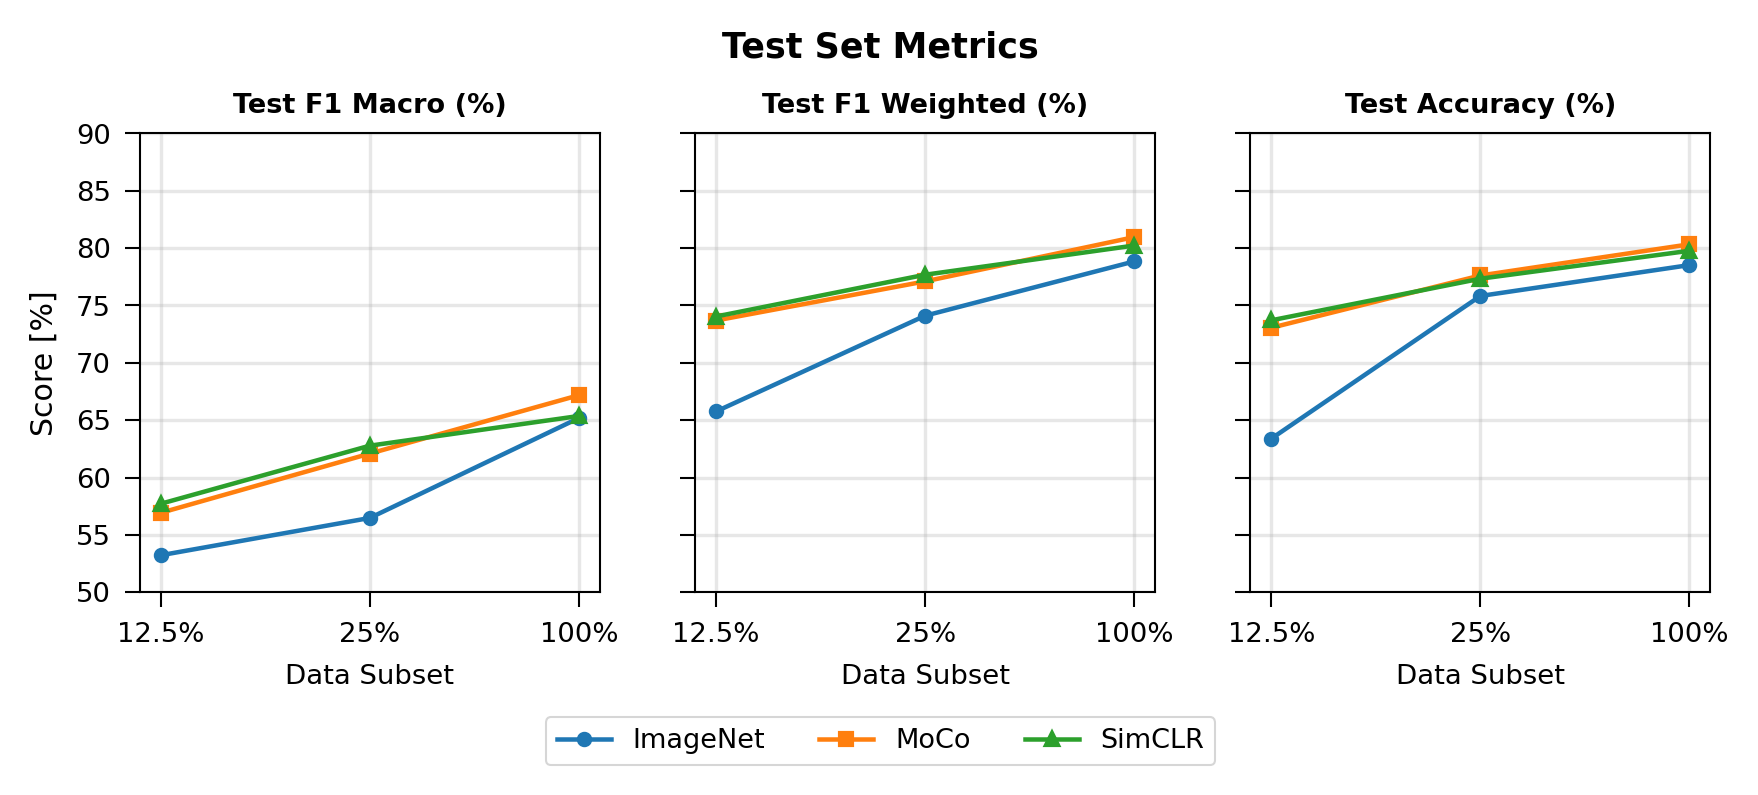

In [ ]:
# === Visualization of test results ===
Y_MIN, Y_MAX = 50, 90
Y_TICKS = np.arange(Y_MIN, Y_MAX + 1, 5)
subset_order = ["12.5%", "25%", "100%"]

dfp = df_test_clean.copy()
dfp["data_subset"] = pd.Categorical(dfp["data_subset"], categories=subset_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(FIG_WIDTH, FIG_HEIGHT), sharex=True, sharey=True)


# List of metrics to plot
metrics = [
    ("test_f1_macro",    "Test F1 Macro (%)"),
    ("test_f1_weighted", "Test F1 Weighted (%)"),
    ("test_accuracy",    "Test Accuracy (%)")
]

for ax, (metric, title) in zip(axes, metrics):
    for model, g in dfp.groupby("model"):
        g = g.sort_values("data_subset")
        ax.plot(
            g["data_subset"], g[metric],
            marker=model_markers[model], linewidth=LINE_WIDTH*1.2, markersize=MARKER_SIZE* 1.2,
            label=model, color=model_colors[model]
        )
    ax.set_title(title, fontsize=TITLE_SIZE * 1.3, fontweight="bold", pad=5)
    ax.set_xlabel("Data Subset", fontsize=LABEL_SIZE * 1.1)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=TICK_SIZE * 1.1,width=0.5)
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # domyślnie ~1.0

axes[0].set_ylabel("Score [%]", fontsize=LABEL_SIZE * 1.2   )
for ax in axes:
    ax.set_ylim(Y_MIN, Y_MAX)
    ax.set_yticks(Y_TICKS)

# Oś X
for ax in axes:
    ax.set_xticks(subset_order)

# Unified legend at the bottom
plt.subplots_adjust(bottom=0.28, top=0.88)

handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="lower center", ncol=3, frameon=True, 
          bbox_to_anchor=(0.5, -0.05), fontsize=LEGEND_SIZE * 1.3)
legend.get_frame().set_linewidth(0.5)  # Cieńsza ramka legendy
plt.suptitle("Test Set Metrics", fontsize=SUPTITLE_SIZE * 1.2, fontweight="bold", y=0.91)
plt.tight_layout()
fig.savefig("test_results.png", bbox_inches="tight", dpi=300)

plt.show()

In [291]:
def compute_all_margins(df):
    subsets = df["data_subset"].unique()
    rows = []
    for subset in subsets:
        row = {"data_subset": subset}
        for metric in ["test_f1_macro", "test_f1_weighted", "test_accuracy"]:
            pivot = df.pivot(index="data_subset", columns="model", values=metric)
            row[f"{metric}_MoCo-ImageNet"] = pivot.loc[subset, "MoCo"] - pivot.loc[subset, "ImageNet"]
            row[f"{metric}_SimCLR-ImageNet"] = pivot.loc[subset, "SimCLR"] - pivot.loc[subset, "ImageNet"]
        rows.append(row)

    return pd.DataFrame(rows)

margin_table = compute_all_margins(dfp)
margin_table

,data_subset,test_f1_macro_MoCo-ImageNet,test_f1_macro_SimCLR-ImageNet,test_f1_weighted_MoCo-ImageNet,test_f1_weighted_SimCLR-ImageNet,test_accuracy_MoCo-ImageNet,test_accuracy_SimCLR-ImageNet
0,12.5%,3.698012,4.489142,7.931328,8.280477,9.6710,10.3221
1,25%,5.610880,6.299931,2.991619,3.572165,1.7872,1.5047
2,100%,1.988018,0.175692,2.117578,1.384099,1.8121,1.2480


Across all models, performance on the test set consistently increases as the proportion of labeled training data grows from 12.5% to 25% and 100%, confirming that all approaches benefit from additional supervision. Self-supervised models (MoCo and SimCLR) outperform the ImageNet-initialized baseline across all data scales and evaluation metrics (F1 Macro, F1 Weighted, and Accuracy). SSL methods demonstrate a clear advantage in settings with limited labeled data: for example, at 12.5% of the training data, both MoCo and SimCLR exceed the performance of ImageNet on all metrics. Moreover, for F1 Macro, both SSL models trained on 12.5% of the data surpass the ImageNet model trained on 25%, indicating that comparable or superior performance can be achieved with twice fewer labeled samples. For F1 Weighted, MoCo and SimCLR at 12.5% achieve results that are essentially on par with ImageNet at 25%, reflecting a substantial label-efficiency benefit of SSL. As the dataset size increases to 100%, the performance gap between models narrows, with ImageNet reducing but not closing the gap entirely, indicating that SSL retains an advantage even under full supervision.
Overall, the results highlight the practical relevance of SSL pretraining in annotation-constrained medical scenarios, where even limited labeled data can yield performance that matches or surpasses that of supervised pretraining.


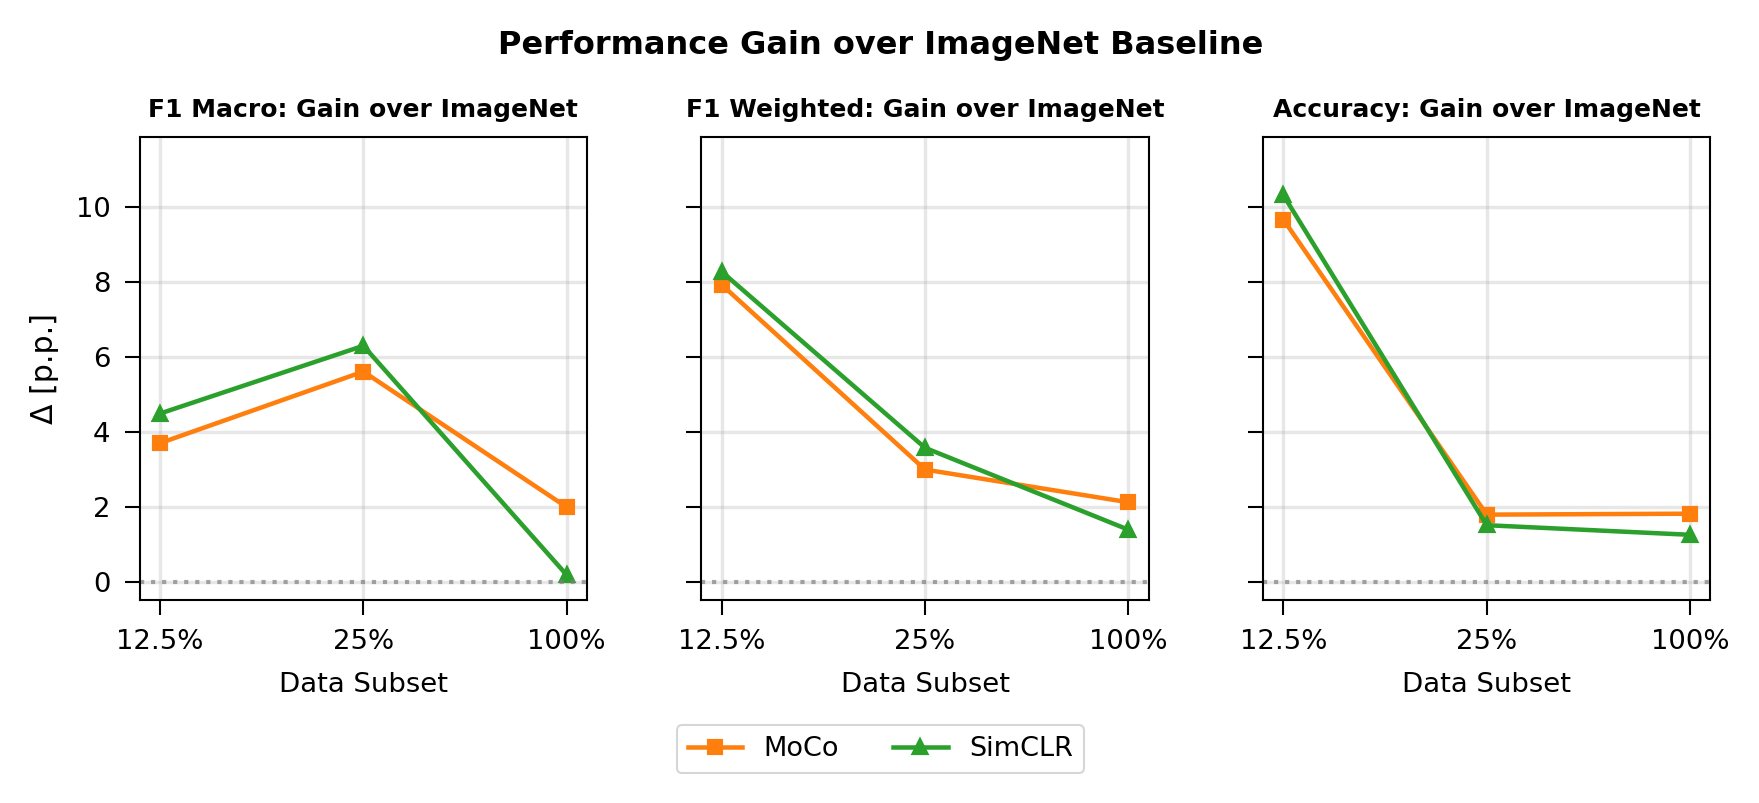

In [ ]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

df = df_test_clean.copy()

def subset_to_float(x):
    m = re.search(r"[\d\.]+", str(x))
    return float(m.group()) if m else np.nan

df["subset_num"] = df["data_subset"].apply(subset_to_float)
df = df.sort_values(["subset_num","model"])

base = (df[df["model"]=="ImageNet"]
        .set_index("data_subset")[["test_f1_macro","test_f1_weighted","test_accuracy"]]
        .rename(columns={"test_f1_macro":"base_macro",
                         "test_f1_weighted":"base_weighted",
                         "test_accuracy":"base_acc"}))

df = df.join(base, on="data_subset")

df["delta_macro"]    = df["test_f1_macro"]    - df["base_macro"]
df["delta_weighted"] = df["test_f1_weighted"] - df["base_weighted"]
df["delta_acc"]      = df["test_accuracy"]    - df["base_acc"]

fig, axes = plt.subplots(1, 3, figsize=(FIG_WIDTH, FIG_HEIGHT), sharex=False, sharey=True)
plots = [
    ("delta_macro",    "F1 Macro: Gain over ImageNet"),
    ("delta_weighted", "F1 Weighted: Gain over ImageNet"),
    ("delta_acc",      "Accuracy: Gain over ImageNet"),
]
for ax, (col, title) in zip(axes, plots):
    y_min = df[col].min()
    y_max = df[col].max()
    margin = (y_max - y_min) * 0.15 if y_max != y_min else 0.1  
    for model, g in df.groupby("model"):
        if model == "ImageNet":  
            continue
        g = g.sort_values("subset_num")
        ax.plot(g["data_subset"], g[col], marker=model_markers[model], 
                linewidth=LINE_WIDTH * 1.2, markersize=MARKER_SIZE* 1.2, label=model,
                color=model_colors[model])
    ax.axhline(0, ls=":", color="gray", alpha=0.7, linewidth=1)
    ax.set_title(title, fontsize=TITLE_SIZE * 1.2, fontweight="bold", pad=5)
    ax.set_xlabel("Data Subset", fontsize=LABEL_SIZE * 1.1)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=TICK_SIZE * 1.1, width=0.5)
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  
    ax.set_ylim(-0.5, y_max + margin)

axes[0].set_ylabel("Δ [p.p.]", fontsize=LABEL_SIZE * 1.2)

plt.subplots_adjust(bottom=0.25, top=0.88)

handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="lower center", ncol=2, frameon=True, 
          bbox_to_anchor=(0.5, -0.05), fontsize=LEGEND_SIZE* 1.3)
legend.get_frame().set_linewidth(0.5)  

plt.suptitle("Performance Gain over ImageNet Baseline", fontsize=SUPTITLE_SIZE* 1.1, 
             fontweight="bold", y=0.92)
plt.tight_layout( w_pad=1.5)
fig.savefig("ssl_gain_over_imagenet.png", bbox_inches="tight", dpi=300)
plt.show()


In [ ]:
def winners(df_metric, metric):
    idx = df_metric.groupby("data_subset")[metric].idxmax()
    return (df_metric.loc[idx, ["data_subset","model",metric]]
            .sort_values("data_subset")
            .reset_index(drop=True))

w_macro    = winners(df, "test_f1_macro")
w_weighted = winners(df, "test_f1_weighted")
w_acc      = winners(df, "test_accuracy")

print("Winners — F1 Macro:\n",    w_macro.to_string(index=False))
print("\nWinners — F1 Weighted:\n", w_weighted.to_string(index=False))
print("\nWinners — Accuracy:\n",    w_acc.to_string(index=False))

Winners — F1 Macro:
 data_subset  model  test_f1_macro
      12.5% SimCLR      57.711273
        25% SimCLR      62.774589
       100%   MoCo      67.176518

Winners — F1 Weighted:
 data_subset  model  test_f1_weighted
      12.5% SimCLR         74.034684
        25% SimCLR         77.676492
       100%   MoCo         80.956114

Winners — Accuracy:
 data_subset  model  test_accuracy
      12.5% SimCLR        73.7025
        25%   MoCo        77.6118
       100%   MoCo        80.3307


Across all data subsets and evaluation metrics, self-supervised models (MoCo and SimCLR) consistently outperform the supervised ImageNet baseline, confirming the effectiveness of SSL pretraining in low- and mid-data regimes. SimCLR achieves the best performance at 12.5% and 25% of labeled data across all metrics, demonstrating stronger label efficiency and early generalization. As the dataset size increases to 100%, MoCo surpasses all models, indicating that its representations continue to benefit from additional supervision and scale more effectively with data. Overall, these results suggest that SimCLR generalizes better with limited labeled data, while MoCo achieves higher final performance when more annotated samples are available, and both approaches provide clear advantages over supervised initialization.

## 4. Validation vs Test Comparison

In [297]:
# Combine data for Val vs Test comparison
# Prepare comparison data
comparison_data = []

for _, row_val in df_train_val.iterrows():
    model = row_val['model']
    subset = row_val['data_subset']
    
    # Find corresponding row in test data
    test_row = df_test_clean[(df_test_clean['model'] == model) & 
                            (df_test_clean['data_subset'] == subset)]
    
    if not test_row.empty:
        test_row = test_row.iloc[0]
        comparison_data.append({
            'model': model,
            'data_subset': subset,
            'val_f1_macro': row_val['val_f1_macro'],  # using renamed column
            'test_f1_macro': test_row['test_f1_macro'],
            'val_f1_weighted': row_val['val_f1_weighted'],  # using renamed column
            'test_f1_weighted': test_row['test_f1_weighted'], 
            'val_accuracy': row_val['val_accuracy'],  # using renamed column
            'test_accuracy': test_row['test_accuracy']
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison["data_subset"] = pd.Categorical(df_comparison["data_subset"], categories=subset_order, ordered=True)

print("📊 Prepared comparison data Val vs Test")
print(f"Shape: {df_comparison.shape}")
print("\nPreview:")
print(df_comparison.head())

📊 Prepared comparison data Val vs Test
Shape: (9, 8)

Preview:
      model data_subset  val_f1_macro  test_f1_macro  val_f1_weighted  \
0  ImageNet       12.5%     53.743988      53.222131        67.475332   
1  ImageNet         25%     60.420523      56.474658        77.857857   
2  ImageNet        100%     64.809127      65.188500        79.446512   
3      MoCo       12.5%     56.055963      56.920143        74.060891   
4      MoCo         25%     64.665731      62.085538        80.777248   

   test_f1_weighted  val_accuracy  test_accuracy  
0         65.754207       64.5076        63.3804  
1         74.104327       78.3905        75.8246  
2         78.838536       78.7604        78.5186  
3         73.685535       72.9294        73.0514  
4         77.095946       80.6107        77.6118  


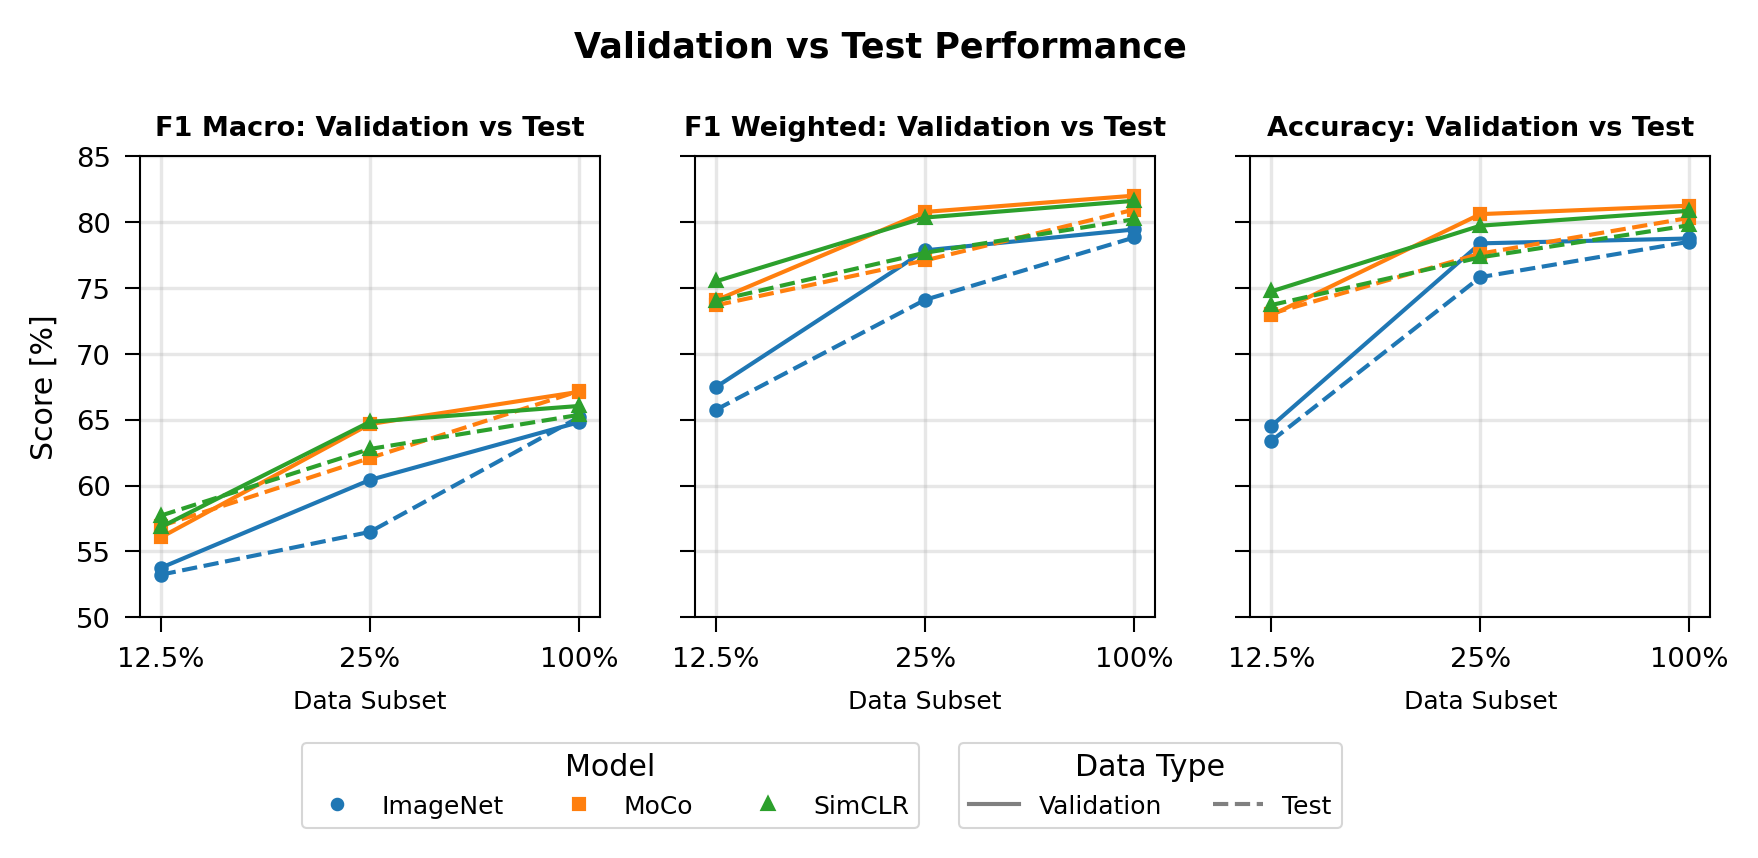

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

subset_order = ["12.5%", "25%", "100%"]
dfc = df_comparison.copy()
dfc["data_subset"] = pd.Categorical(dfc["data_subset"], categories=subset_order, ordered=True)


COMMON_LIMS = (50, 85)
YLIMS= {"macro": COMMON_LIMS, "weighted": COMMON_LIMS, "acc": COMMON_LIMS}

titles = [
    ("F1 Macro: Validation vs Test", "val_f1_macro", "test_f1_macro", YLIMS["macro"]),
    ("F1 Weighted: Validation vs Test", "val_f1_weighted", "test_f1_weighted", YLIMS["weighted"]),
    ("Accuracy: Validation vs Test", "val_accuracy", "test_accuracy", YLIMS["acc"]),
]

# --- Figure ---
fig, axes = plt.subplots(1, 3, figsize=(FIG_WIDTH, FIG_HEIGHT), sharey=True)

for ax, (title, val_col, test_col, ylim) in zip(axes, titles):
    for model, g in dfc.groupby("model"):
        g = g.sort_values("data_subset")
        # Validation - solid line
        ax.plot(g["data_subset"], g[val_col], "-", marker=model_markers[model],
                linewidth=LINE_WIDTH * 1.1, markersize=MARKER_SIZE * 1.1, color=model_colors[model])
        ax.plot(g["data_subset"], g[test_col], "--", marker=model_markers[model],
                linewidth=LINE_WIDTH * 1.1, markersize=MARKER_SIZE * 1.1, color=model_colors[model])
    ax.set_title(title, fontsize=TITLE_SIZE * 1.3, fontweight="bold", pad=5)
    ax.set_xlabel("Data Subset", fontsize=LABEL_SIZE)
    ax.set_ylim(*ylim)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(subset_order)
    ax.tick_params(labelsize=TICK_SIZE * 1.1, width=0.5)
    for spine in ax.spines.values():
        spine.set_linewidth(0.5) 

axes[0].set_ylabel("Score [%]", fontsize=LABEL_SIZE * 1.2)

plt.subplots_adjust(bottom=0.23, top=0.88)

# Legend 1: Models (colors and markers) - left side
model_handles = [Line2D([0], [0], color=model_colors[m], marker=model_markers[m],
                        linestyle='', markersize=MARKER_SIZE, label=m)
                 for m in ["ImageNet", "MoCo", "SimCLR"]]
leg1 = fig.legend(handles=model_handles, loc="lower center", ncol=3, frameon=True,
                  bbox_to_anchor=(0.35, -0.1), fontsize=LEGEND_SIZE * 1.2, title="Model",
                  title_fontsize=LABEL_TITLE_FONTSIZE * 1.2)

leg1.get_frame().set_linewidth(0.5)  
style_handles = [
    Line2D([0], [0], color="gray", linestyle='-', linewidth=LINE_WIDTH * 1.1, label="Validation"),
    Line2D([0], [0], color="gray", linestyle='--', linewidth=LINE_WIDTH * 1.1 , label="Test")
]
leg2 = fig.legend(handles=style_handles, loc="lower center", ncol=2, frameon=True,
                  bbox_to_anchor=(0.65, -0.1), fontsize=LEGEND_SIZE*1.2, title="Data Type",
                  title_fontsize=LABEL_TITLE_FONTSIZE * 1.2)
leg2.get_frame().set_linewidth(0.5)  

plt.suptitle("Validation vs Test Performance", fontsize=SUPTITLE_SIZE * 1.2, 
             fontweight="bold", y=0.94)
plt.tight_layout()
fig.savefig("val_test_comparison.png", bbox_inches="tight", dpi=300)
plt.show()


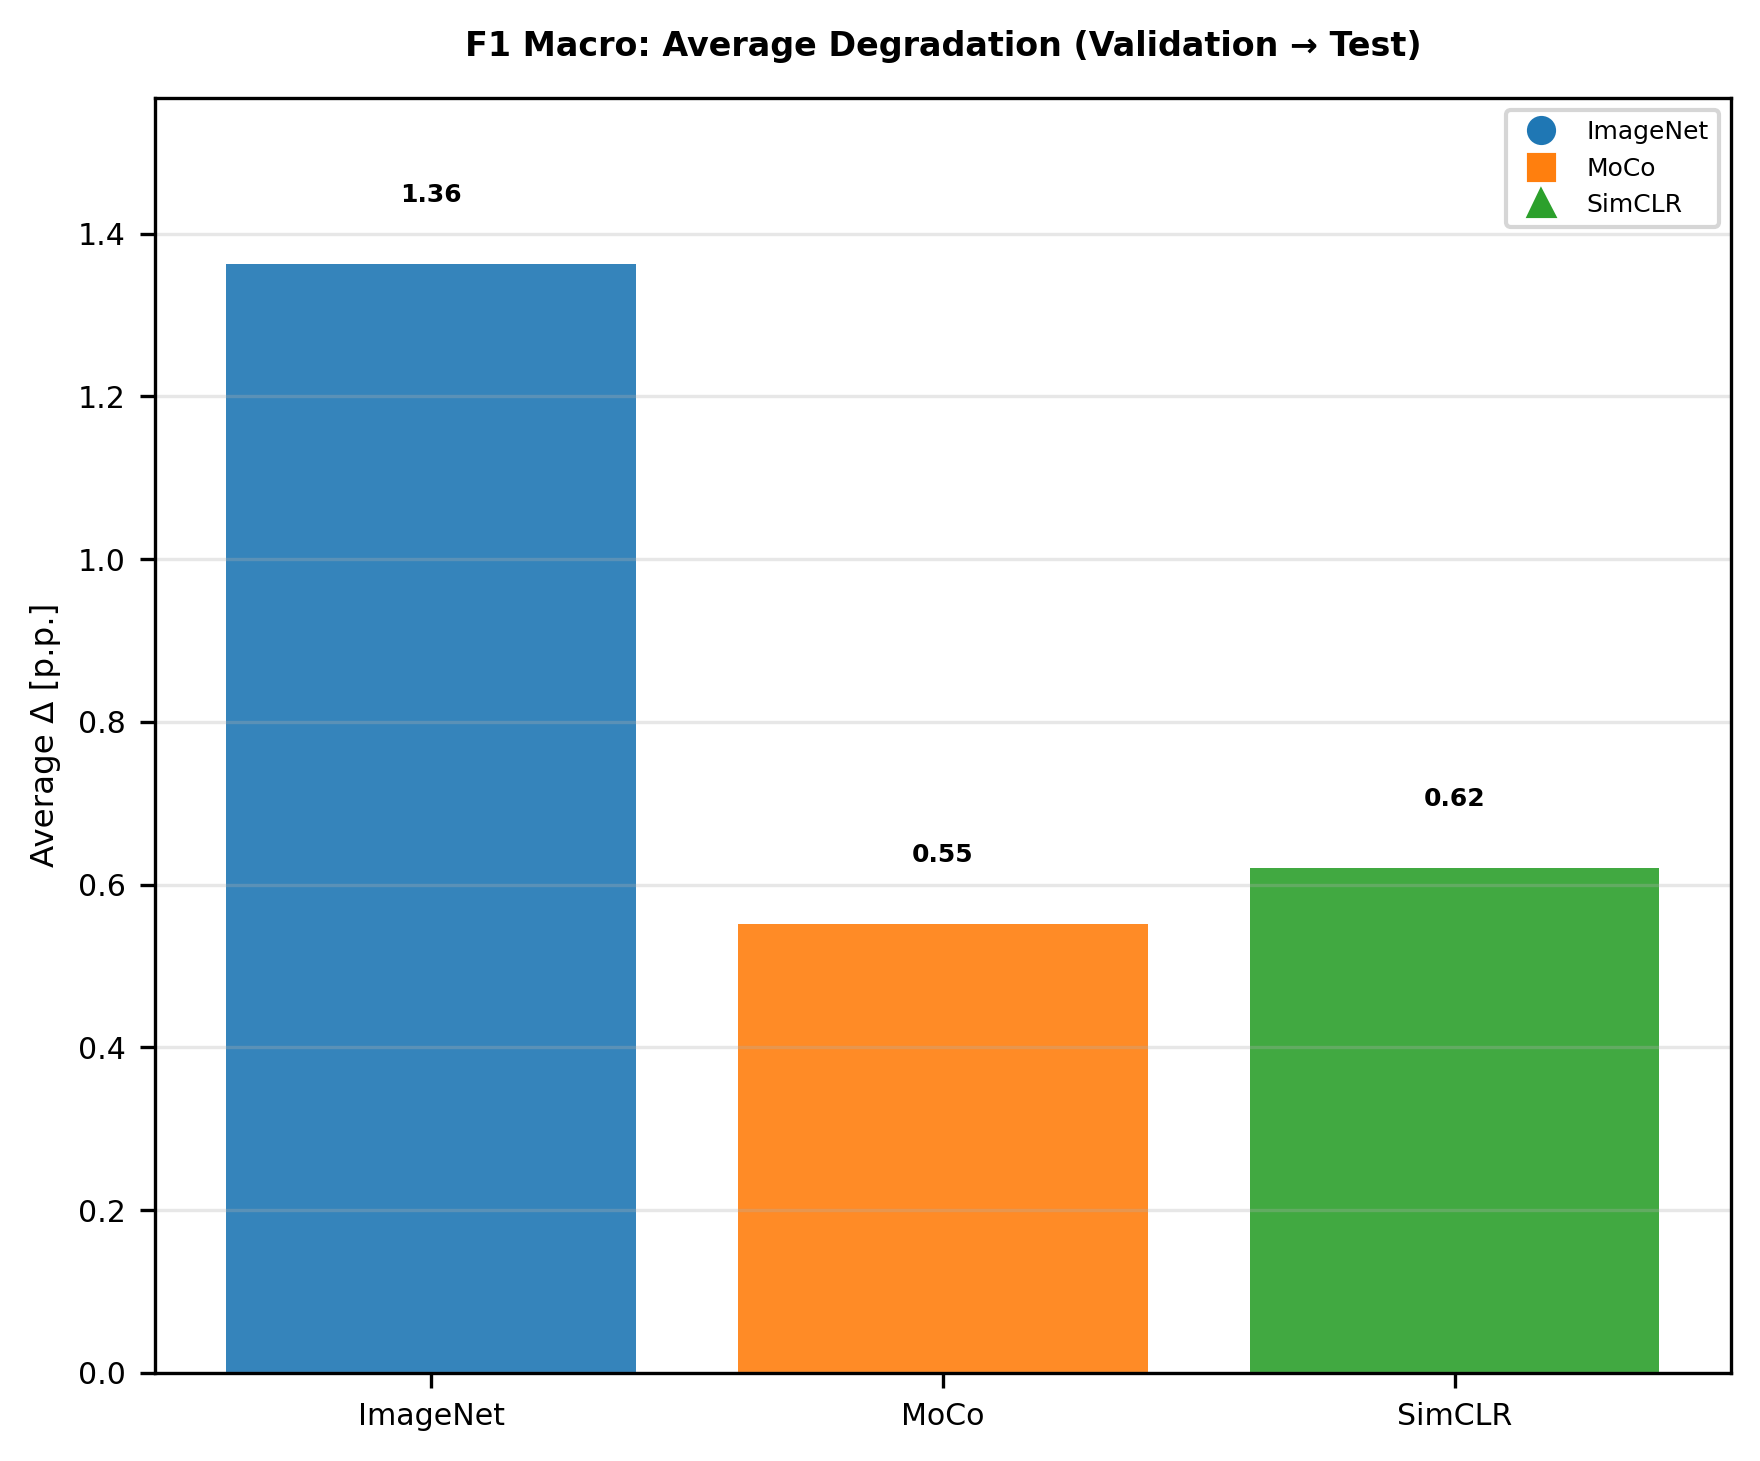

In [ ]:
# === Average F1 Macro Degradation (Val → Test) ===

fig, ax = plt.subplots(figsize=(6, 5))  

avg_drop = (
    df_comparison["val_f1_macro"] - df_comparison["test_f1_macro"]
).groupby(df_comparison["model"]).mean()

bars = ax.bar(
    avg_drop.index,
    avg_drop.values,
    color=[model_colors[m] for m in avg_drop.index],
    alpha=0.9,
)

for b, v in zip(bars, avg_drop.values):
    ax.text(
        b.get_x() + b.get_width() / 2,
        v + (0.07 if v >= 0 else -0.25),
        f"{v:.2f}",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=TICK_SIZE,
    )

ax.set_title(
    "F1 Macro: Average Degradation (Validation → Test)",
    fontsize=TITLE_SIZE*1.6,
    fontweight="bold",
    pad=10,
)
ax.set_ylabel("Average Δ [p.p.]", fontsize=LABEL_SIZE*1.3)
ax.grid(True, axis="y", alpha=0.3)
ax.tick_params(labelsize=TICK_SIZE * 1.2)
ax.margins(y=0.15)

handles = [
    plt.Line2D([0], [0], marker=model_markers[m], color=model_colors[m], linestyle="", label=m)
    for m in avg_drop.index
]
ax.legend(handles=handles, loc="upper right", frameon=True, fontsize=LEGEND_SIZE * 1.2)
plt.tight_layout()
fig.savefig("val_test_gap.png", bbox_inches="tight", dpi=300)
plt.show()


In [ ]:
print("="*80)
print("📊 DETAILED COMPARISON ANALYSIS - VALIDATION vs TEST PERFORMANCE")
print("="*80)

print("\n🔸 1. INDIVIDUAL MODEL PERFORMANCE BY DATA SUBSET:")
print("-"*60)

for subset in subset_order:
    print(f"\n📈 DATA SUBSET: {subset}")
    print("="*40)
    
    subset_comparison = df_comparison[df_comparison["data_subset"] == subset]
    
    for _, row in subset_comparison.iterrows():
        model = row["model"]
        val_f1 = row["val_f1_macro"]
        test_f1 = row["test_f1_macro"]
        degradation = val_f1 - test_f1
        
        val_f1_weighted = row["val_f1_weighted"]
        test_f1_weighted = row["test_f1_weighted"]
        degradation_weighted = val_f1_weighted - test_f1_weighted
        
        val_acc = row["val_accuracy"]
        test_acc = row["test_accuracy"]
        degradation_acc = val_acc - test_acc
        
        print(f"\n{model}:")
        print(f"  F1 Macro:     Val={val_f1:.2f}%  Test={test_f1:.2f}%  Drop={degradation:.2f}pp")
        print(f"  F1 Weighted:  Val={val_f1_weighted:.2f}%  Test={test_f1_weighted:.2f}%  Drop={degradation_weighted:.2f}pp")
        print(f"  Accuracy:     Val={val_acc:.2f}%  Test={test_acc:.2f}%  Drop={degradation_acc:.2f}pp")

print("\n\n🔸 2. CROSS-MODEL COMPARISON BY METRIC:")
print("-"*60)

# F1 Macro comparison
print(f"\n📊 F1 MACRO COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_f1_macro']:.1f}".ljust(12)
        line += f"{row['test_f1_macro']:.1f}".ljust(12)
    
    print(line)

# F1 Weighted comparison
print(f"\n📊 F1 WEIGHTED COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_f1_weighted']:.1f}".ljust(12)
        line += f"{row['test_f1_weighted']:.1f}".ljust(12)
    
    print(line)

# Accuracy comparison
print(f"\n📊 ACCURACY COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_accuracy']:.1f}".ljust(12)
        line += f"{row['test_accuracy']:.1f}".ljust(12)
    
    print(line)

print("\n\n🔸 3. PERFORMANCE DEGRADATION ANALYSIS:")
print("-"*60)

print(f"\n📉 AVERAGE DEGRADATION BY MODEL (Val → Test):")
for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model]
    
    avg_f1_drop = (model_data["val_f1_macro"] - model_data["test_f1_macro"]).mean()
    avg_f1w_drop = (model_data["val_f1_weighted"] - model_data["test_f1_weighted"]).mean()
    avg_acc_drop = (model_data["val_accuracy"] - model_data["test_accuracy"]).mean()
    
    print(f"\n{model}:")
    print(f"  F1 Macro Drop:    {avg_f1_drop:.2f} pp")
    print(f"  F1 Weighted Drop: {avg_f1w_drop:.2f} pp")
    print(f"  Accuracy Drop:    {avg_acc_drop:.2f} pp")

print(f"\n📉 DEGRADATION BY DATA SUBSET:")
for subset in subset_order:
    subset_data = df_comparison[df_comparison["data_subset"] == subset]
    
    avg_f1_drop = (subset_data["val_f1_macro"] - subset_data["test_f1_macro"]).mean()
    avg_f1w_drop = (subset_data["val_f1_weighted"] - subset_data["test_f1_weighted"]).mean()
    avg_acc_drop = (subset_data["val_accuracy"] - subset_data["test_accuracy"]).mean()
    
    print(f"\n{subset} Data:")
    print(f"  Avg F1 Macro Drop:    {avg_f1_drop:.2f} pp")
    print(f"  Avg F1 Weighted Drop: {avg_f1w_drop:.2f} pp")
    print(f"  Avg Accuracy Drop:    {avg_acc_drop:.2f} pp")

print("\n\n🔸 4. RANKING ANALYSIS:")
print("-"*60)

print(f"\n🏆 BEST MODELS BY METRIC AND SUBSET (Test Results):")

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    
    best_f1_macro = subset_data.loc[subset_data["test_f1_macro"].idxmax()]
    best_f1_weighted = subset_data.loc[subset_data["test_f1_weighted"].idxmax()]
    best_accuracy = subset_data.loc[subset_data["test_accuracy"].idxmax()]
    
    print(f"\n{subset} Data:")
    print(f"  Best F1 Macro:    {best_f1_macro['model']} ({best_f1_macro['test_f1_macro']:.2f}%)")
    print(f"  Best F1 Weighted: {best_f1_weighted['model']} ({best_f1_weighted['test_f1_weighted']:.2f}%)")
    print(f"  Best Accuracy:    {best_accuracy['model']} ({best_accuracy['test_accuracy']:.2f}%)")

print(f"\n🔄 CONSISTENCY ANALYSIS:")
print(f"Models that achieve best performance across multiple metrics/subsets:")

# Count wins per model
model_wins = {'ImageNet': 0, 'MoCo': 0, 'SimCLR': 0}

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    
    best_f1_macro_model = subset_data.loc[subset_data["test_f1_macro"].idxmax(), "model"]
    best_f1_weighted_model = subset_data.loc[subset_data["test_f1_weighted"].idxmax(), "model"]
    best_accuracy_model = subset_data.loc[subset_data["test_accuracy"].idxmax(), "model"]
    
    model_wins[best_f1_macro_model] += 1
    model_wins[best_f1_weighted_model] += 1
    model_wins[best_accuracy_model] += 1

print(f"\nTotal wins (across all metrics and subsets):")
for model, wins in sorted(model_wins.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model}: {wins}/9 possible wins")

print("\n" + "="*80)
print("✅ DETAILED COMPARISON ANALYSIS COMPLETED")
print("="*80)

📊 DETAILED COMPARISON ANALYSIS - VALIDATION vs TEST PERFORMANCE

🔸 1. INDIVIDUAL MODEL PERFORMANCE BY DATA SUBSET:
------------------------------------------------------------

📈 DATA SUBSET: 12.5%

ImageNet:
  F1 Macro:     Val=53.74%  Test=53.22%  Drop=0.52pp
  F1 Weighted:  Val=67.48%  Test=65.75%  Drop=1.72pp
  Accuracy:     Val=64.51%  Test=63.38%  Drop=1.13pp

MoCo:
  F1 Macro:     Val=56.06%  Test=56.92%  Drop=-0.86pp
  F1 Weighted:  Val=74.06%  Test=73.69%  Drop=0.38pp
  Accuracy:     Val=72.93%  Test=73.05%  Drop=-0.12pp

SimCLR:
  F1 Macro:     Val=56.84%  Test=57.71%  Drop=-0.87pp
  F1 Weighted:  Val=75.51%  Test=74.03%  Drop=1.47pp
  Accuracy:     Val=74.74%  Test=73.70%  Drop=1.03pp

📈 DATA SUBSET: 25%

ImageNet:
  F1 Macro:     Val=60.42%  Test=56.47%  Drop=3.95pp
  F1 Weighted:  Val=77.86%  Test=74.10%  Drop=3.75pp
  Accuracy:     Val=78.39%  Test=75.82%  Drop=2.57pp

MoCo:
  F1 Macro:     Val=64.67%  Test=62.09%  Drop=2.58pp
  F1 Weighted:  Val=80.78%  Test=77.10%  Drop

## 5. Summary Tables

In [305]:
# Summary tables
print("=" * 100)
print("📊 SUMMARY TABLE - VALIDATION RESULTS (Train/Val)")
print("=" * 100)
print(df_train_val.round(2).to_string(index=False))

print("\n" + "=" * 100)
print("📊 SUMMARY TABLE - TEST RESULTS")
print("=" * 100)
print(df_test_clean.round(2).to_string(index=False))

print("\n" + "=" * 100)
print("📊 COMPARISON TABLE - VALIDATION vs TEST")
print("=" * 100)
print(df_comparison.round(2).to_string(index=False))

📊 SUMMARY TABLE - VALIDATION RESULTS (Train/Val)
   model data_subset             job_directory                                                                                                    job_path                                                                                                                checkpoint_path  checkpoint_exists  best_phase  best_train_phase  val_f1_macro  val_f1_weighted  val_accuracy  train_f1_macro  train_f1_weighted  train_accuracy
ImageNet       12.5% job_1952602_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/finetuning/imagenet_to_surgvu/12/job_1952602_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/finetuning/imagenet_to_surgvu/12/job_1952602_20251015_1437/model_phase1.torch               True           3                 1         53.74            67.48         64.51           61.09              71.28           69.52
ImageNet         25% job_1952603_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/f

In [306]:
# Best models analysis
print("\n" + "=" * 100)
print("🏆 BEST MODELS BY DATA SUBSET (by Test F1 Macro)")
print("=" * 100)

# Best on validation
print("\n🔸 VALIDATION:")
for subset in subset_order:
    subset_data = df_train_val[df_train_val["data_subset"] == subset]
    if subset_data.empty:
        continue
    best_row = subset_data.loc[subset_data["val_f1_macro"].idxmax()]
    print(f"\n{subset} Data:")
    print(f"  🥇 Best Model: {best_row['model']}")
    print(f"  📊 Val F1 Macro: {best_row['val_f1_macro']:.2f}%")
    print(f"  📊 Val F1 Weighted: {best_row['val_f1_weighted']:.2f}%")
    print(f"  📊 Val Accuracy: {best_row['val_accuracy']:.2f}%")
    print(f"  🎯 Best Phase: {int(best_row['best_phase'])}")

# Best on test
print("\n🔸 TEST:")
for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    if subset_data.empty:
        continue
    best_row = subset_data.loc[subset_data["test_f1_macro"].idxmax()]
    print(f"\n{subset} Data:")
    print(f"  🥇 Best Model: {best_row['model']}")
    print(f"  📊 Test F1 Macro: {best_row['test_f1_macro']:.2f}%")
    print(f"  📊 Test F1 Weighted: {best_row['test_f1_weighted']:.2f}%")
    print(f"  📊 Test Accuracy: {best_row['test_accuracy']:.2f}%")

# Overall statistics
print("\n" + "=" * 100)
print("📈 OVERALL STATISTICS")
print("=" * 100)

print("\n🔸 AVERAGE RESULTS BY MODEL (Test F1 Macro):")
test_avg = df_test_clean.groupby("model")["test_f1_macro"].mean().sort_values(ascending=False)
for model, avg_score in test_avg.items():
    print(f"  {model}: {avg_score:.2f}%")

print("\n🔸 AVERAGE DEGRADATION VAL → TEST (F1 Macro):")
for model, group in df_comparison.groupby("model"):
    avg_degradation = (group["val_f1_macro"] - group["test_f1_macro"]).mean()
    print(f"  {model}: {avg_degradation:.2f} p.p.")

print("\n🔸 BEST OVERALL RESULT:")
overall_best = df_test_clean.loc[df_test_clean["test_f1_macro"].idxmax()]
print(f"  Model: {overall_best['model']}")
print(f"  Subset: {overall_best['data_subset']}")
print(f"  Test F1 Macro: {overall_best['test_f1_macro']:.2f}%")

print("\n✅ Analysis completed!")


🏆 BEST MODELS BY DATA SUBSET (by Test F1 Macro)

🔸 VALIDATION:

12.5% Data:
  🥇 Best Model: SimCLR
  📊 Val F1 Macro: 56.84%
  📊 Val F1 Weighted: 75.51%
  📊 Val Accuracy: 74.74%
  🎯 Best Phase: 5

25% Data:
  🥇 Best Model: SimCLR
  📊 Val F1 Macro: 64.83%
  📊 Val F1 Weighted: 80.35%
  📊 Val Accuracy: 79.73%
  🎯 Best Phase: 21

100% Data:
  🥇 Best Model: MoCo
  📊 Val F1 Macro: 67.11%
  📊 Val F1 Weighted: 82.01%
  📊 Val Accuracy: 81.25%
  🎯 Best Phase: 17

🔸 TEST:

12.5% Data:
  🥇 Best Model: SimCLR
  📊 Test F1 Macro: 57.71%
  📊 Test F1 Weighted: 74.03%
  📊 Test Accuracy: 73.70%

25% Data:
  🥇 Best Model: SimCLR
  📊 Test F1 Macro: 62.77%
  📊 Test F1 Weighted: 77.68%
  📊 Test Accuracy: 77.33%

100% Data:
  🥇 Best Model: MoCo
  📊 Test F1 Macro: 67.18%
  📊 Test F1 Weighted: 80.96%
  📊 Test Accuracy: 80.33%

📈 OVERALL STATISTICS

🔸 AVERAGE RESULTS BY MODEL (Test F1 Macro):
  MoCo: 62.06%
  SimCLR: 61.95%
  ImageNet: 58.30%

🔸 AVERAGE DEGRADATION VAL → TEST (F1 Macro):
  ImageNet: 1.36 p.p.
  

# Analysis of per-class performance



In [ ]:
import seaborn as sns
import json

In [ ]:
# === HELPER FUNCTIONS ===

# Surgical class names (in order by indices in JSON)
CLASS_NAMES = [
    "Other",
    "Suturing",
    "Uterine horn",
    "Rectal artery/vein",
    "Suspensory ligaments",
    "Skills application",
    "Retraction and collision avoidance",
    "Range of motion"
]

def load_f1_report(model_dir: str, subset: str) -> dict:
    """Load f1_full_report.json for a given model and data subset."""
    report_path = BASE_DIR / "testing" / model_dir / subset / "f1_full_report.json"
    
    if not report_path.exists():
        print(f"⚠️  File not found: {report_path}")
        return None
    
    try:
        with open(report_path, 'r') as f:
            data = json.load(f)
        # Return first element of array (contains data from last timestamp)
        return data[0] if isinstance(data, list) and len(data) > 0 else data
    except Exception as e:
        print(f"❌ Error loading {report_path}: {e}")
        return None


def extract_class_metrics(report: dict, model_name: str, subset: str) -> pd.DataFrame:
    """Extract metrics for individual classes from F1 report."""
    if report is None:
        return pd.DataFrame()
    
    rows = []
    
    # Check data structure
    if 'per_class' not in report:
        print(f"⚠️  Missing 'per_class' key in report for {model_name} - {subset}")
        return pd.DataFrame()
    
    per_class = report['per_class']
    
    # Iterate through classes using indices
    num_classes = len(per_class.get('precision', []))
    
    for idx in range(num_classes):
        class_name = CLASS_NAMES[idx] if idx < len(CLASS_NAMES) else f"Class_{idx}"
        
        rows.append({
            'model': model_name,
            'data_subset': SUBSET_LABEL[subset],
            'subset_num': float(subset if subset != "12" else "12.5"),
            'class': class_name,
            'precision': per_class['precision'][idx],
            'recall': per_class['recall'][idx],
            'f1-score': per_class['f1'][idx],
            'support': per_class['support'][idx]
        })
    
    return pd.DataFrame(rows)


def collect_all_class_data() -> pd.DataFrame:
    """Collect data for all classes from all models and subsets."""
    all_data = []
    
    print("📂 Loading data from f1_full_report.json files...\n")
    
    for model_dir, model_name in MODEL_DIR_TO_NAME.items():
        for subset in SUBSETS:
            print(f"  🔍 {model_name} - {SUBSET_LABEL[subset]}")
            report = load_f1_report(model_dir, subset)
            
            if report:
                df = extract_class_metrics(report, model_name, subset)
                all_data.append(df)
                print(f"     ✅ Loaded {len(df)} classes")
            else:
                print(f"     ❌ No data")
    
    if not all_data:
        print("\n⚠️  No data found!")
        return pd.DataFrame()
    
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\n✅ Total: {len(combined_df)} records for {combined_df['class'].nunique()} unique classes\n")
    
    return combined_df


def analyze_class_representation(df: pd.DataFrame):
    """Analyze representation of individual classes."""
    
    print("="*80)
    print("📊 CLASS-LEVEL PERFORMANCE ANALYSIS")
    print("="*80)
    
    # 1. Support statistics (number of samples) per class
    print("\n🔸 1. SAMPLE DISTRIBUTION (SUPPORT) PER CLASS:")
    print("-"*60)
    
    support_by_class = df.groupby('class')['support'].first().sort_values(ascending=False)
    
    print(f"\nTotal number of classes: {len(support_by_class)}")
    print(f"Average samples per class: {support_by_class.mean():.1f}")
    print(f"Median: {support_by_class.median():.1f}")
    print(f"Std dev: {support_by_class.std():.1f}\n")
    
    print("All classes (from most frequent):")
    for class_name, count in support_by_class.items():
        print(f"  {class_name}: {int(count)} samples")
    
    # 2. Performance per class (average F1 score)
    print("\n\n🔸 2. MODEL PERFORMANCE PER CLASS (average F1-score):")
    print("-"*60)
    
    avg_f1_by_class = df.groupby('class')['f1-score'].mean().sort_values(ascending=False)
    
    print(f"\nAverage F1-score across all classes: {avg_f1_by_class.mean():.3f}")
    
    print("\nAll classes (from best performing):")
    for class_name, f1 in avg_f1_by_class.items():
        support = support_by_class[class_name]
        print(f"  {class_name}: F1={f1:.3f} (support={int(support)})")
    
    # 3. Correlation between support and F1-score
    print("\n\n🔸 3. CORRELATION: NUMBER OF SAMPLES vs PERFORMANCE:")
    print("-"*60)
    
    class_summary = pd.DataFrame({
        'support': support_by_class,
        'avg_f1': avg_f1_by_class
    })
    
    correlation = class_summary['support'].corr(class_summary['avg_f1'])
    print(f"\nPearson correlation between support and F1-score: {correlation:.3f}")
    
    if correlation > 0.5:
        print("➡️  Strong positive correlation - classes with more samples are better recognized")
    elif correlation > 0.3:
        print("➡️  Moderate positive correlation")
    elif correlation > 0:
        print("➡️  Weak positive correlation")
    else:
        print("➡️  No positive correlation or negative correlation")
    
    # Weight (inverse of support) vs F1 correlation
    class_summary['weight'] = 1.0 / class_summary['support']
    weight_f1_corr = class_summary['weight'].corr(class_summary['avg_f1'])
    print(f"\nPearson correlation between class weight (1/support) and F1-score: {weight_f1_corr:.3f}")
    if weight_f1_corr < -0.3:
        print("➡️  Classes with higher weight (fewer samples) have significantly lower F1-scores")
        print("     This confirms the importance of balanced training data.")
    elif weight_f1_corr < 0:
        print("➡️  Weak negative correlation - underrepresented classes tend to perform slightly worse")
    else:
        print("➡️  No clear negative correlation detected")
    
    # 4. Analysis per model
    print("\n\n🔸 4. MODEL COMPARISON - PERFORMANCE PER CLASS:")
    print("-"*60)
    
    for model in ['ImageNet', 'MoCo', 'SimCLR']:
        model_df = df[df['model'] == model]
        avg_f1 = model_df.groupby('class')['f1-score'].mean().mean()
        print(f"\n{model}: average F1-score = {avg_f1:.3f}")
        
        # Find classes where model performs best/worst
        f1_by_class = model_df.groupby('class')['f1-score'].mean().sort_values(ascending=False)
        
        print(f"  Best classes:")
        for class_name, f1 in f1_by_class.head(3).items():
            print(f"    {class_name}: {f1:.3f}")
        
        print(f"  Worst classes:")
        for class_name, f1 in f1_by_class.tail(3).items():
            print(f"    {class_name}: {f1:.3f}")
    
    # 5. Data scaling trends per class
    print("\n\n🔸 5. DATA SCALING TRENDS (12.5% → 100%):")
    print("-"*60)
    
    # Calculate F1 improvement from smallest to largest subset per class
    subset_trends = []
    for class_name in df['class'].unique():
        class_data = df[df['class'] == class_name].groupby('subset_num')['f1-score'].mean()
        if 12.5 in class_data.index and 100 in class_data.index:
            f1_12 = class_data[12.5]
            f1_100 = class_data[100]
            improvement = f1_100 - f1_12
            relative_improvement = (improvement / f1_12 * 100) if f1_12 > 0 else 0
            
            subset_trends.append({
                'class': class_name,
                'f1_12.5%': f1_12,
                'f1_100%': f1_100,
                'absolute_gain': improvement,
                'relative_gain_%': relative_improvement
            })
    
    subset_trends_df = pd.DataFrame(subset_trends).sort_values('absolute_gain', ascending=False)
    
    print("\nClasses that BENEFIT MOST from more data:")
    for _, row in subset_trends_df.head(3).iterrows():
        print(f"  {row['class']}:")
        print(f"     F1 @ 12.5%: {row['f1_12.5%']:.3f}  →  F1 @ 100%: {row['f1_100%']:.3f}")
        print(f"     Absolute gain: +{row['absolute_gain']:.3f}  |  Relative gain: +{row['relative_gain_%']:.1f}%")
    
    print("\nClasses that show PLATEAU or MINIMAL improvement:")
    for _, row in subset_trends_df.tail(2).iterrows():
        print(f"  {row['class']}:")
        print(f"     F1 @ 12.5%: {row['f1_12.5%']:.3f}  →  F1 @ 100%: {row['f1_100%']:.3f}")
        print(f"     Absolute gain: {row['absolute_gain']:+.3f}  |  Relative gain: {row['relative_gain_%']:+.1f}%")
        if row['absolute_gain'] < 0.01:
            print(f"     → This class may be saturated or requires different training strategies")
    
    return class_summary, subset_trends_df


def create_class_visualizations(df: pd.DataFrame, class_summary: pd.DataFrame, subset_trends_df: pd.DataFrame):
    """Create visualizations for class analysis."""
    
    print("\n\n📊 Creating visualizations...")
    
    # Increased font sizes for class plots (multipliers applied to base sizes)
    CLASS_TITLE_SIZE = int(TITLE_SIZE * 2.2)
    CLASS_LABEL_SIZE = int(LABEL_SIZE * 1.7)
    CLASS_TICK_SIZE = int(TICK_SIZE * 1.7 )
    
    # 1. Average F1 per class (horizontal bar chart)
    print("📊 Creating average performance per class plot...")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    avg_f1_sorted = class_summary['avg_f1'].sort_values()
    bars = ax.barh(range(len(avg_f1_sorted)), avg_f1_sorted.values, 
                   color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=0.8)
    ax.set_yticks(range(len(avg_f1_sorted)))
    ax.set_yticklabels(avg_f1_sorted.index, fontsize=CLASS_TICK_SIZE)
    ax.set_xlabel('Average F1-score', fontsize=CLASS_LABEL_SIZE, fontweight='bold')
    ax.set_title('Average F1-score per Class', fontsize=CLASS_TITLE_SIZE, fontweight='bold', pad=10)
    ax.margins(x=0.1)  
    ax.grid(True, alpha=0.3, axis='x')
    ax.tick_params(labelsize=CLASS_TICK_SIZE)
    
    # Add values on bars
    for i, v in enumerate(avg_f1_sorted.values):
        ax.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=CLASS_TICK_SIZE)
    
    plt.tight_layout()
    output_file = "class_average_performance.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_file}")
    plt.show()
    plt.close()
    
    # 2. Heatmap: F1-score per class per model
    print("📊 Creating F1-score heatmap per class per model...")
    
    pivot_data = df.pivot_table(
        index='class', 
        columns='model', 
        values='f1-score', 
        aggfunc='mean'
    )
    # Order columns
    pivot_data = pivot_data[['ImageNet', 'MoCo', 'SimCLR']]
    
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn', 
                center=0.5, vmin=0.2, vmax=0.9, linewidths=0.5, 
                cbar_kws={'label': 'F1-score'},
                annot_kws={'fontsize': CLASS_TICK_SIZE},
                ax=ax)
    ax.set_title('F1-score per Class per Model', fontsize=CLASS_TITLE_SIZE, fontweight='bold', pad=10)
    ax.set_xlabel('Model', fontsize=CLASS_LABEL_SIZE, fontweight='bold')
    ax.set_ylabel('Class', fontsize=CLASS_LABEL_SIZE, fontweight='bold')
    ax.tick_params(labelsize=CLASS_TICK_SIZE)
    plt.tight_layout()
    output_file =  "class_f1_heatmap.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_file}")
    plt.show()
    plt.close()
    
    # 3. Data scaling trends - Absolute gain
    print("📊 Creating data scaling impact plot...")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    sorted_trends = subset_trends_df.sort_values('absolute_gain', ascending=True)
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in sorted_trends['absolute_gain']]
    ax.barh(range(len(sorted_trends)), sorted_trends['absolute_gain'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.8)
    ax.set_yticks(range(len(sorted_trends)))
    ax.set_yticklabels(sorted_trends['class'], fontsize=CLASS_TICK_SIZE)
    ax.set_xlabel('Absolute F1 Gain (12.5% → 100%)', fontsize=CLASS_LABEL_SIZE, fontweight='bold')
    ax.set_title('Data Scaling Impact per Class', fontsize=CLASS_TITLE_SIZE, fontweight='bold', pad=10)
    ax.margins(x=0.15)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.grid(True, alpha=0.3, axis='x')
    ax.tick_params(labelsize=CLASS_TICK_SIZE)
    
    # Add values on bars
    for i, v in enumerate(sorted_trends['absolute_gain'].values):
        if v > 0:
            ax.text(v + 0.005, i, f'+{v:.2f}', va='center', fontsize=CLASS_TICK_SIZE)
        else:
            ax.text(v - 0.005, i, f'{v:.2f}', va='center', ha='right', fontsize=CLASS_TICK_SIZE)
    
    plt.tight_layout()
    output_file = "data_scaling_impact_per_class.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_file}")
    plt.show()
    plt.close()
    
    # 4. Data scaling trends - Relative gain
    print("📊 Creating relative improvement plot...")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    sorted_rel = subset_trends_df.sort_values('relative_gain_%', ascending=True)
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in sorted_rel['relative_gain_%']]
    ax.barh(range(len(sorted_rel)), sorted_rel['relative_gain_%'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.8)
    ax.set_yticks(range(len(sorted_rel)))
    ax.set_yticklabels(sorted_rel['class'], fontsize=CLASS_TICK_SIZE)
    ax.set_xlabel('Relative F1 Gain % (12.5% → 100%)', fontsize=CLASS_LABEL_SIZE, fontweight='bold')
    ax.set_title('Relative Improvement per Class', fontsize=CLASS_TITLE_SIZE, fontweight='bold', pad=10)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.grid(True, alpha=0.3, axis='x')
    ax.tick_params(labelsize=CLASS_TICK_SIZE)
    
    # Add values on bars
    for i, v in enumerate(sorted_rel['relative_gain_%'].values):
        if v > 0:
            ax.text(v + 1, i, f'+{v:.1f}%', va='center', fontsize=CLASS_TICK_SIZE)
        else:
            ax.text(v - 1, i, f'{v:.1f}%', va='center', ha='right', fontsize=CLASS_TICK_SIZE)
    
    plt.tight_layout()
    output_file = OUT_DIR / "class_scaling_relative.png"
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f"✅ Saved: {output_file}")
    plt.show()
    plt.close()


def save_class_detailed_reports(df: pd.DataFrame, class_summary: pd.DataFrame, subset_trends_df: pd.DataFrame):
    """Save detailed reports to CSV files."""
    
    print("\n📝 Saving detailed reports...")
    
    # 1. Full data
    output_file = OUT_DIR / "class_metrics_full.csv"
    df.to_csv(output_file, index=False)
    print(f"✅ Saved: {output_file}")
    
    # 2. Summary per class
    output_file = OUT_DIR / "class_summary.csv"
    class_summary.to_csv(output_file)
    print(f"✅ Saved: {output_file}")
    
    # 3. Data scaling trends
    output_file = OUT_DIR / "class_scaling_trends.csv"
    subset_trends_df.to_csv(output_file, index=False)
    print(f"✅ Saved: {output_file}")
    
    # 4. Per model per class
    for model in ['ImageNet', 'MoCo', 'SimCLR']:
        model_df = df[df['model'] == model]
        pivot = model_df.pivot_table(
            index='class',
            columns='data_subset',
            values=['f1-score', 'precision', 'recall'],
            aggfunc='mean'
        )
        output_file = OUT_DIR / f"class_metrics_{model.lower().replace(' ', '_')}.csv"
        pivot.to_csv(output_file)
        print(f"✅ Saved: {output_file}")



📂 Loading data from f1_full_report.json files...

  🔍 ImageNet - 12.5%
     ✅ Loaded 8 classes
  🔍 ImageNet - 25%
     ✅ Loaded 8 classes
  🔍 ImageNet - 100%
     ✅ Loaded 8 classes
  🔍 MoCo - 12.5%
     ✅ Loaded 8 classes
  🔍 MoCo - 25%
     ✅ Loaded 8 classes
  🔍 MoCo - 100%
     ✅ Loaded 8 classes
  🔍 SimCLR - 12.5%
     ✅ Loaded 8 classes
  🔍 SimCLR - 25%
     ✅ Loaded 8 classes
  🔍 SimCLR - 100%
     ✅ Loaded 8 classes

✅ Total: 72 records for 8 unique classes

📊 CLASS-LEVEL PERFORMANCE ANALYSIS

🔸 1. SAMPLE DISTRIBUTION (SUPPORT) PER CLASS:
------------------------------------------------------------

Total number of classes: 8
Average samples per class: 14513.8
Median: 5882.0
Std dev: 25719.3

All classes (from most frequent):
  Other: 77264 samples
  Suturing: 14000 samples
  Uterine horn: 8152 samples
  Rectal artery/vein: 7345 samples
  Suspensory ligaments: 4419 samples
  Skills application: 2739 samples
  Retraction and collision avoidance: 1109 samples
  Range of motion: 1

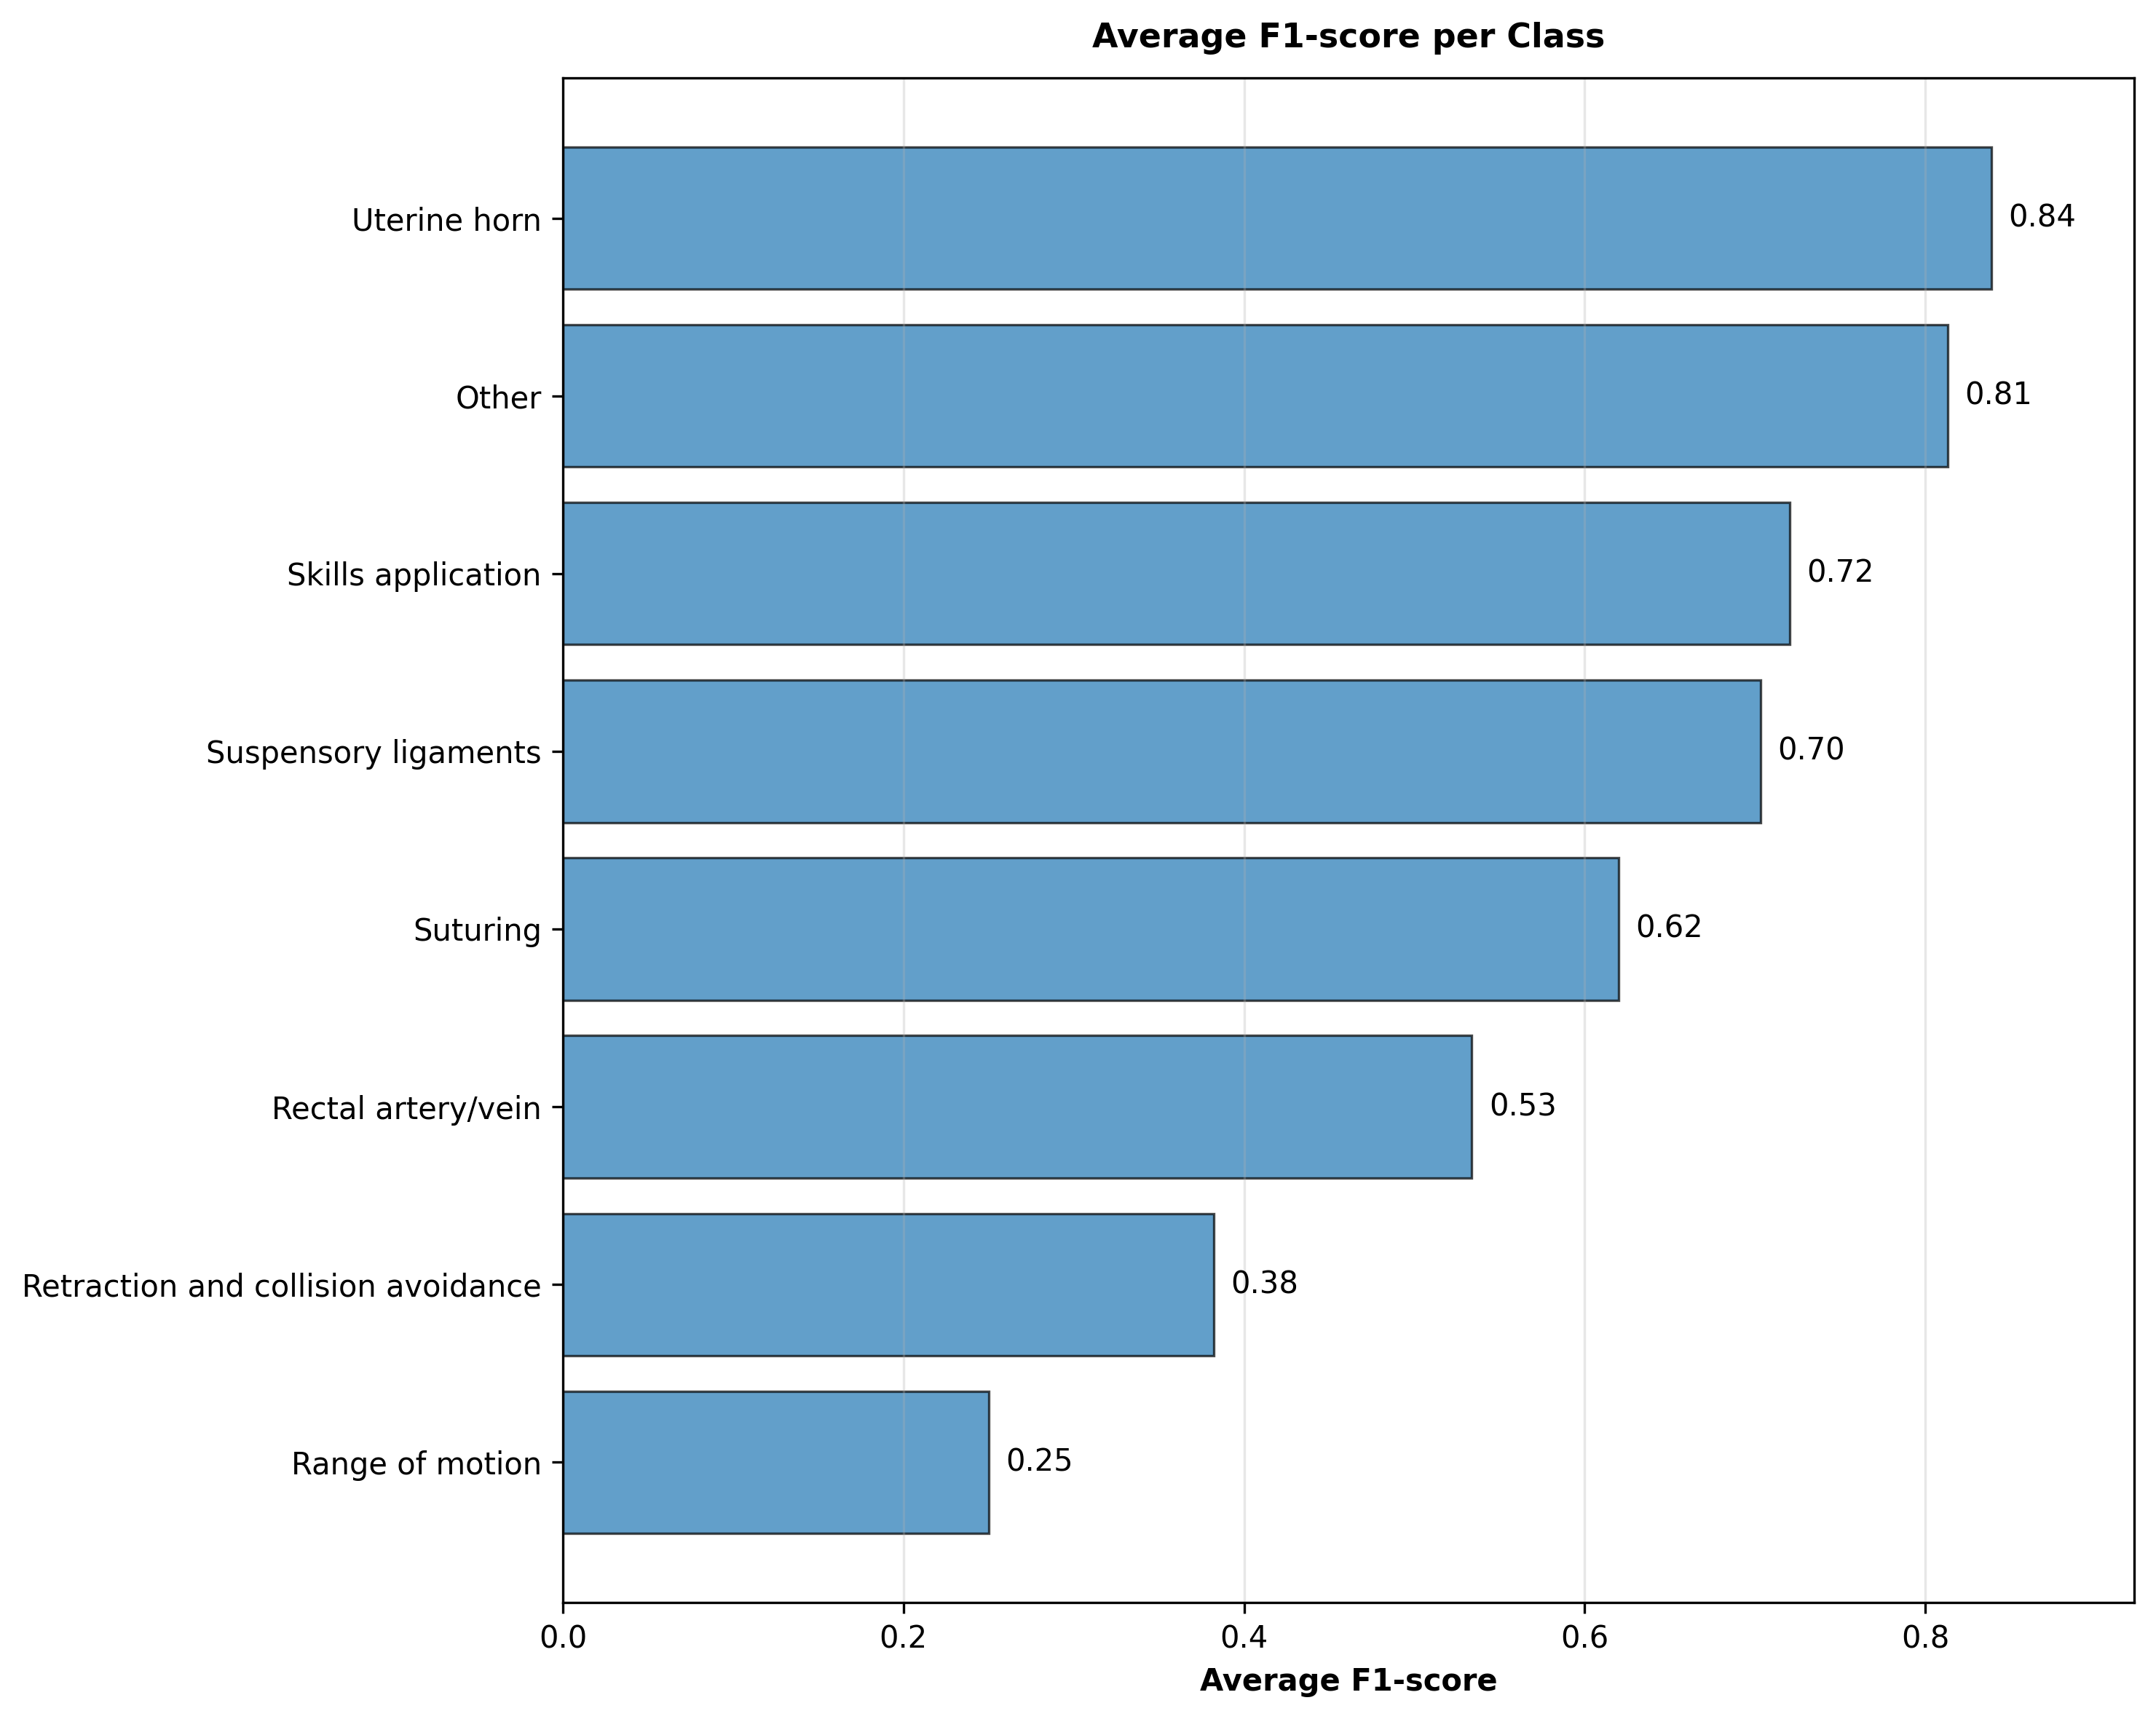

📊 Creating F1-score heatmap per class per model...
✅ Saved: class_f1_heatmap.png


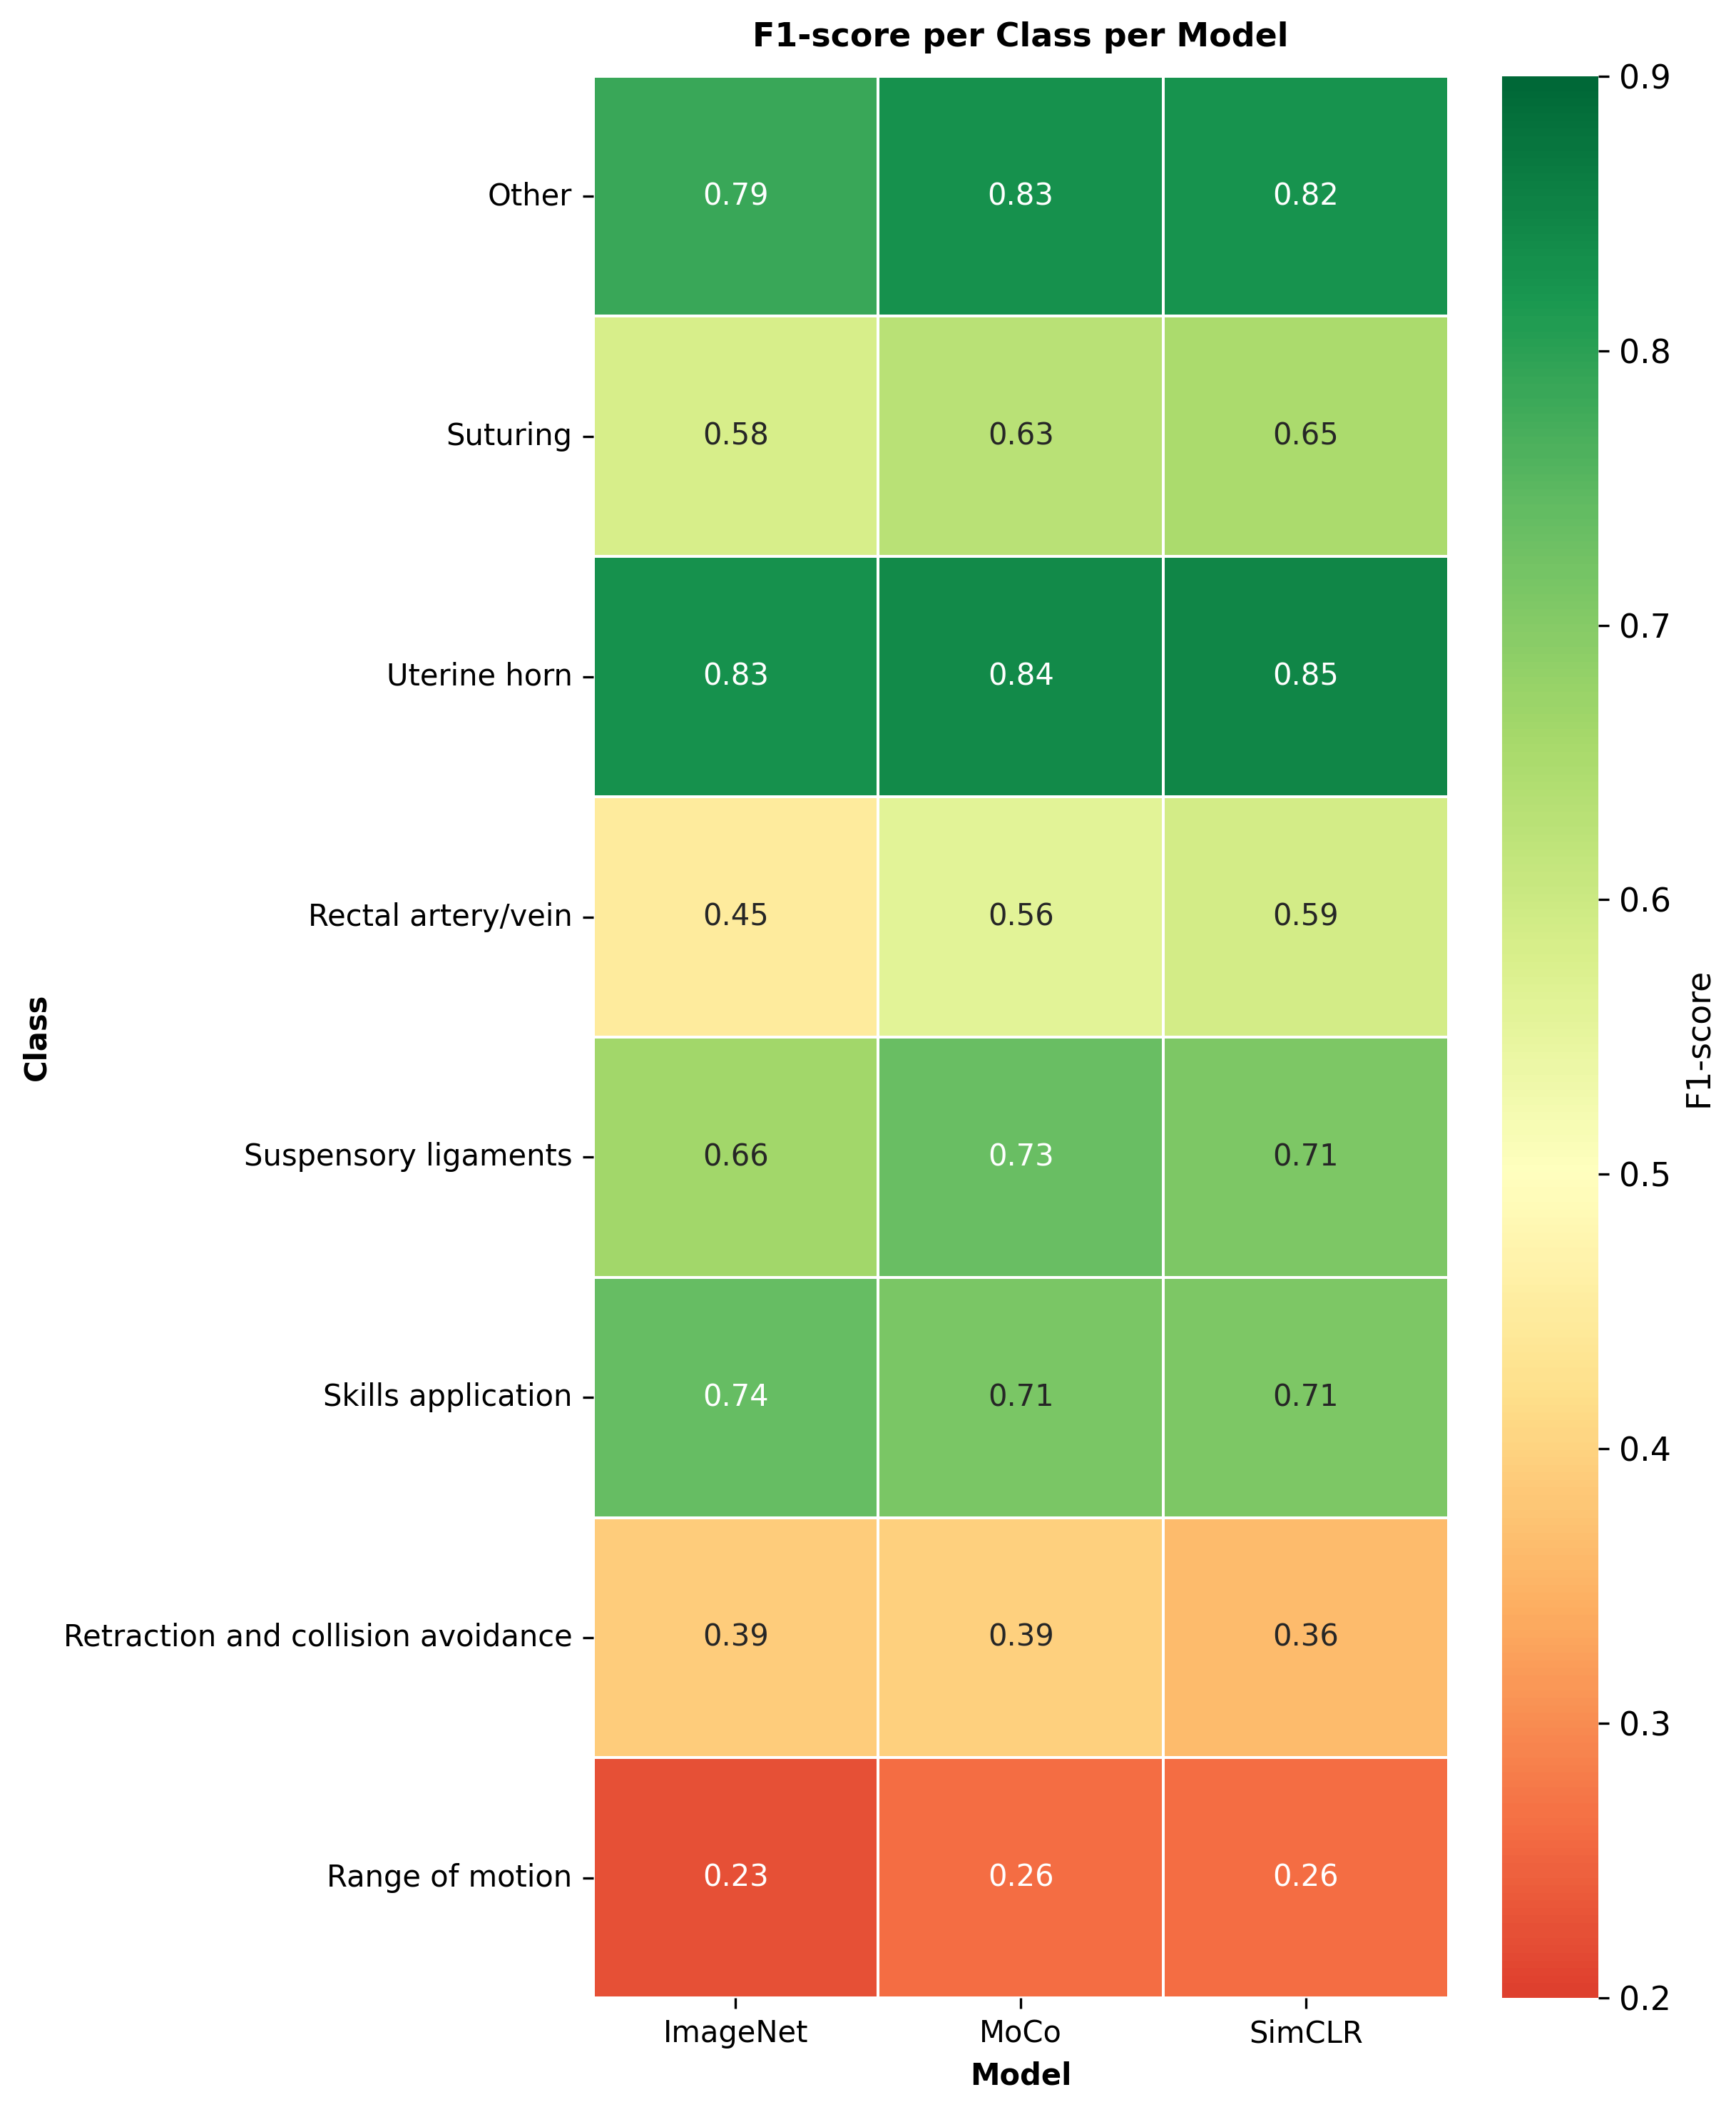

📊 Creating data scaling impact plot...
✅ Saved: data_scaling_impact_per_class.png


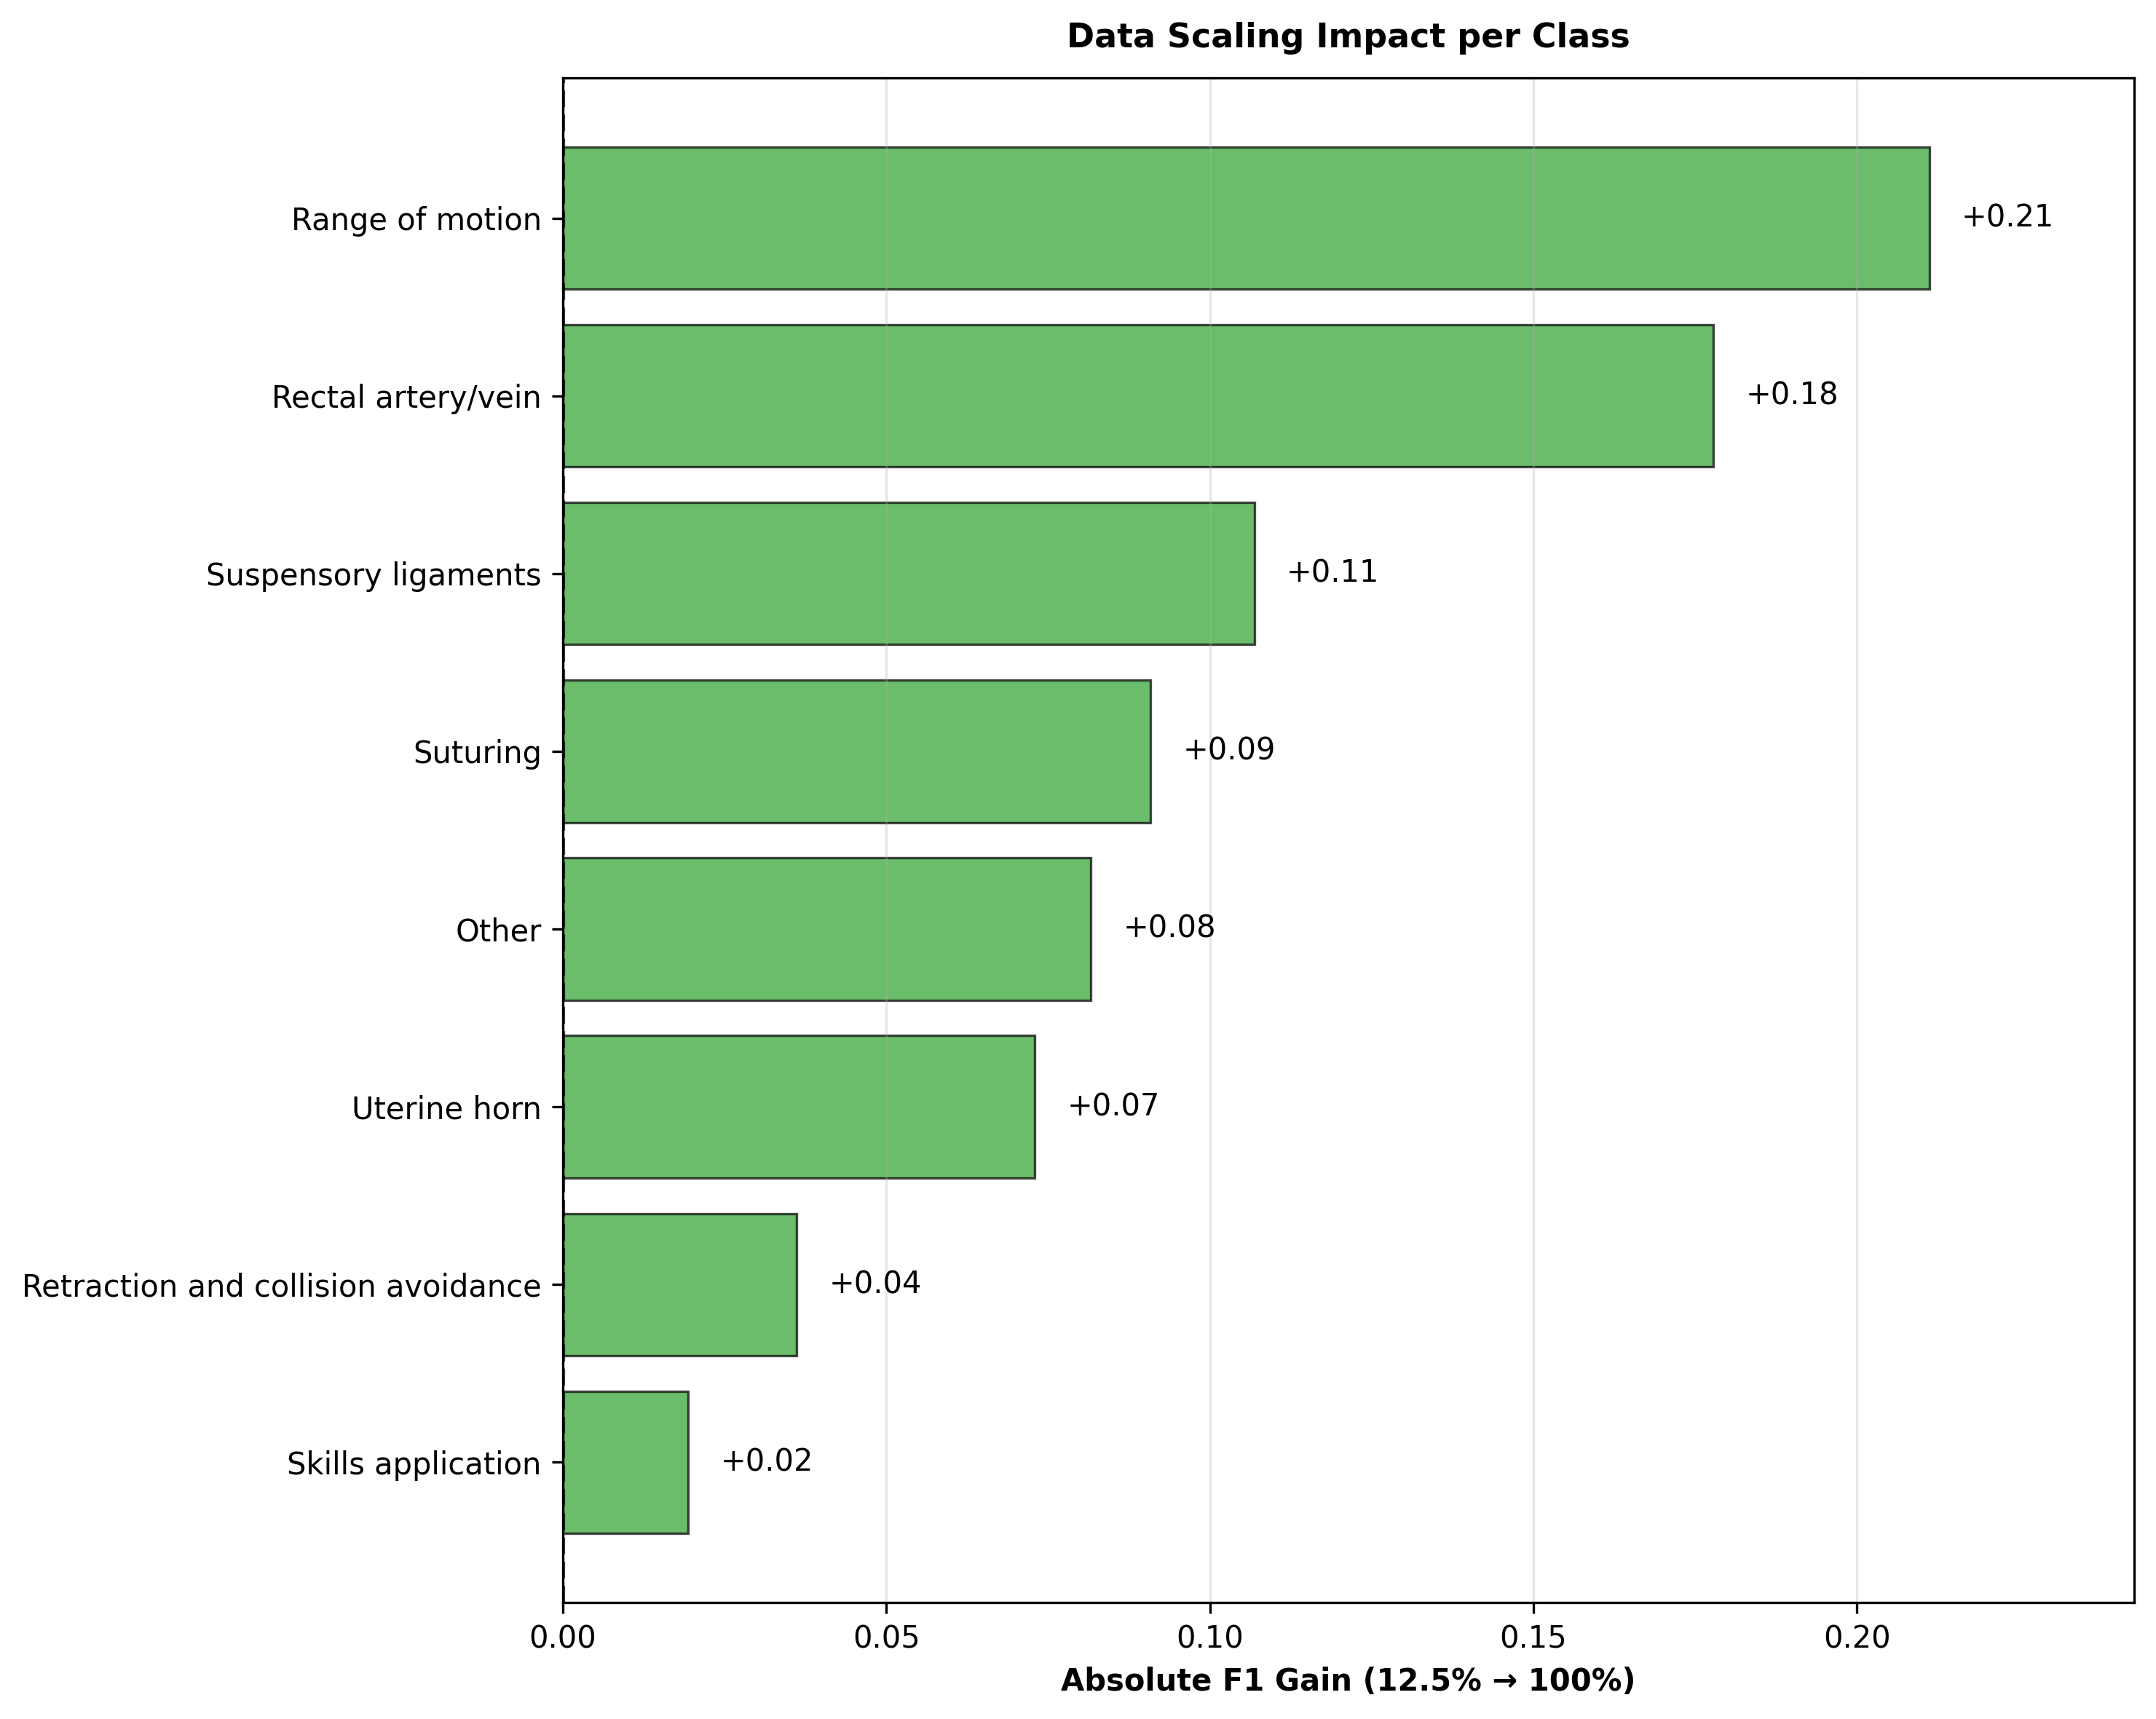

📊 Creating relative improvement plot...
✅ Saved: ../../results/experiments/analysis/class_scaling_relative.png


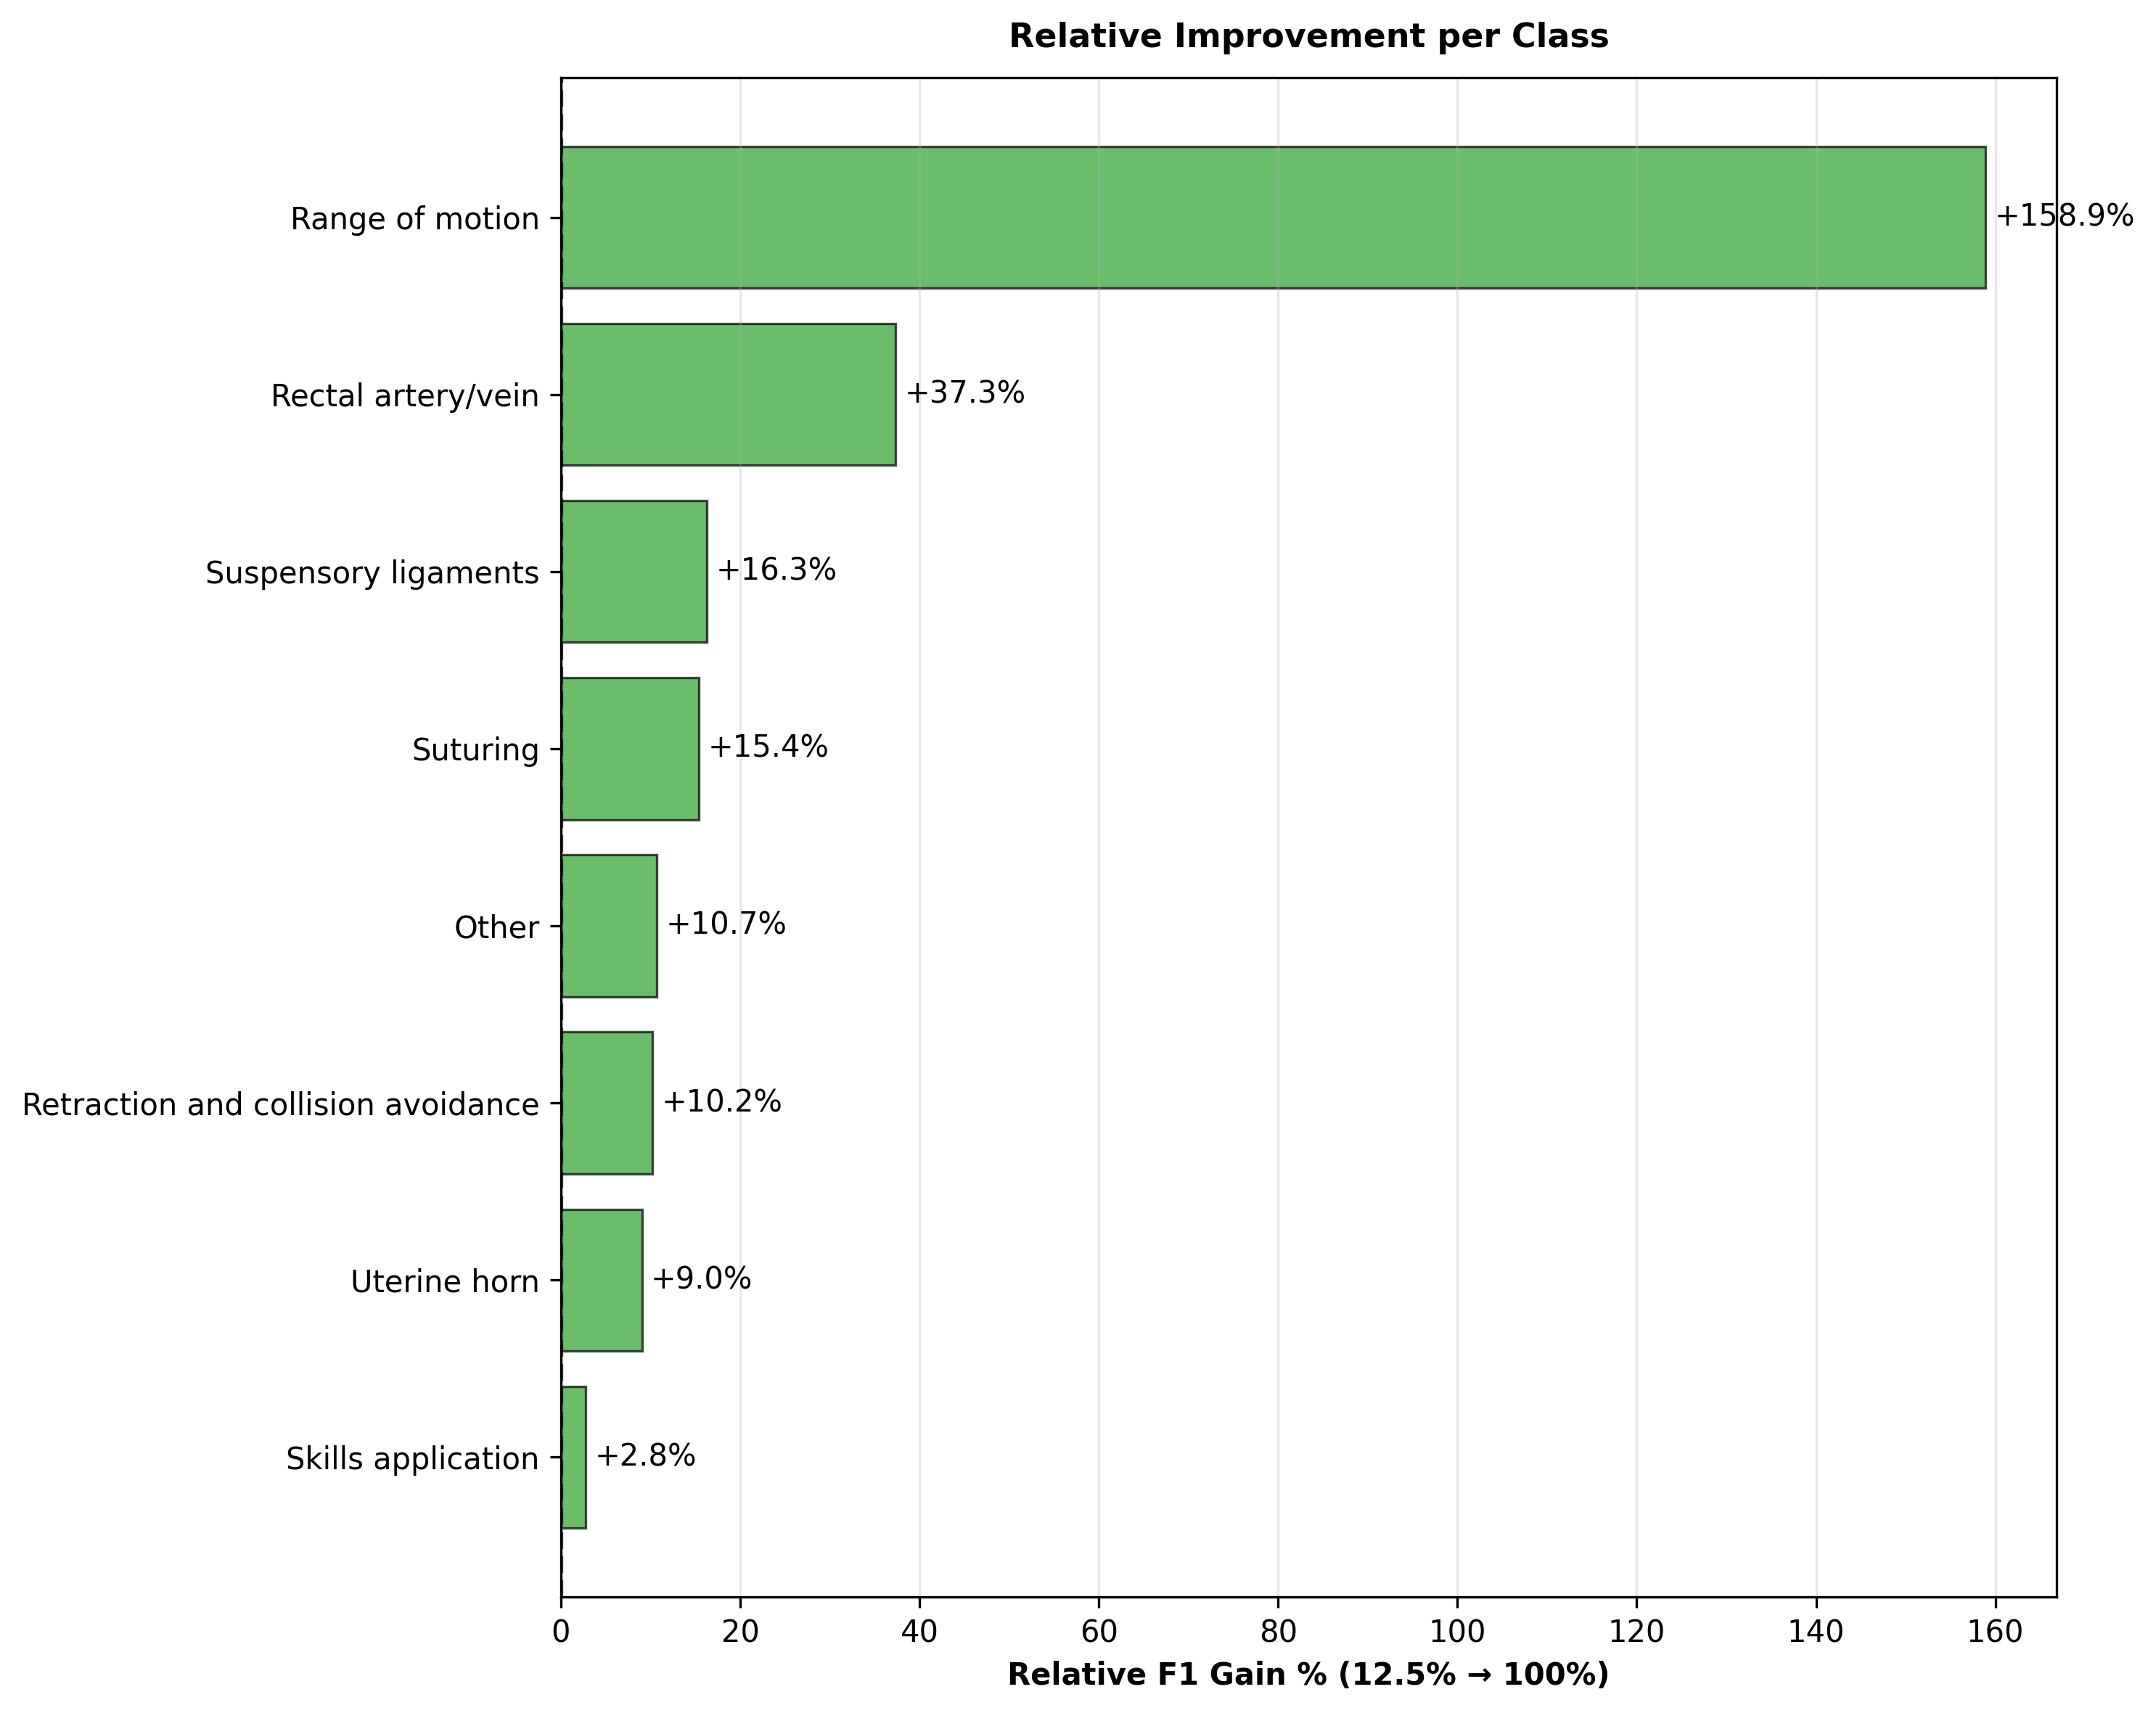


📝 Saving detailed reports...
✅ Saved: ../../results/experiments/analysis/class_metrics_full.csv
✅ Saved: ../../results/experiments/analysis/class_summary.csv
✅ Saved: ../../results/experiments/analysis/class_scaling_trends.csv
✅ Saved: ../../results/experiments/analysis/class_metrics_imagenet.csv
✅ Saved: ../../results/experiments/analysis/class_metrics_moco.csv
✅ Saved: ../../results/experiments/analysis/class_metrics_simclr.csv

✅ CLASS-LEVEL ANALYSIS COMPLETED


In [309]:
# === EXECUTION: CLASS-LEVEL ANALYSIS ===

# 1. Collect all data
df_classes = collect_all_class_data()

df_classes["class"] = pd.Categorical(
    df_classes["class"],
    categories=CLASS_NAMES,
    ordered=True
)


if not df_classes.empty:
    # 2. Perform statistical analysis
    class_summary, subset_trends_df = analyze_class_representation(df_classes)
    
    # 3. Create visualizations
    create_class_visualizations(df_classes, class_summary, subset_trends_df)
    
    # 4. Save detailed reports to CSV
    save_class_detailed_reports(df_classes, class_summary, subset_trends_df)
    
    print("\n" + "="*80)
    print("✅ CLASS-LEVEL ANALYSIS COMPLETED")
    print("="*80)
else:
    print("\n❌ No data available for analysis.")